In [1]:
import validmind as vm

vm.init("test")

/Users/jwalz/Library/Caches/pypoetry/virtualenvs/validmind-mI3jzOkk-py3.10/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


True

In [2]:
import pandas as pd

df = pd.read_csv("datasets/bank_customer_churn.csv")

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="Exited",
    class_labels={
        "0": "Did not exit",
        "1": "Exited",
    }
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5020.520000,1.569047e+07,650.159625,38.948875,5.033875,76434.096511,1.532500,0.702625,0.519875,99790.187959,0.202000
std,2885.718516,7.190247e+04,96.846230,10.458952,2.885267,62612.251258,0.580505,0.457132,0.499636,57520.508892,0.401517
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2518.750000,1.562816e+07,583.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50857.102500,0.000000
50%,5036.500000,1.569014e+07,651.500000,37.000000,5.000000,97263.675000,1.000000,1.000000,1.000000,99504.890000,0.000000
75%,7512.250000,1.575238e+07,717.000000,44.000000,8.000000,128044.507500,2.000000,1.000000,1.000000,149216.320000,0.000000
max,10000.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000

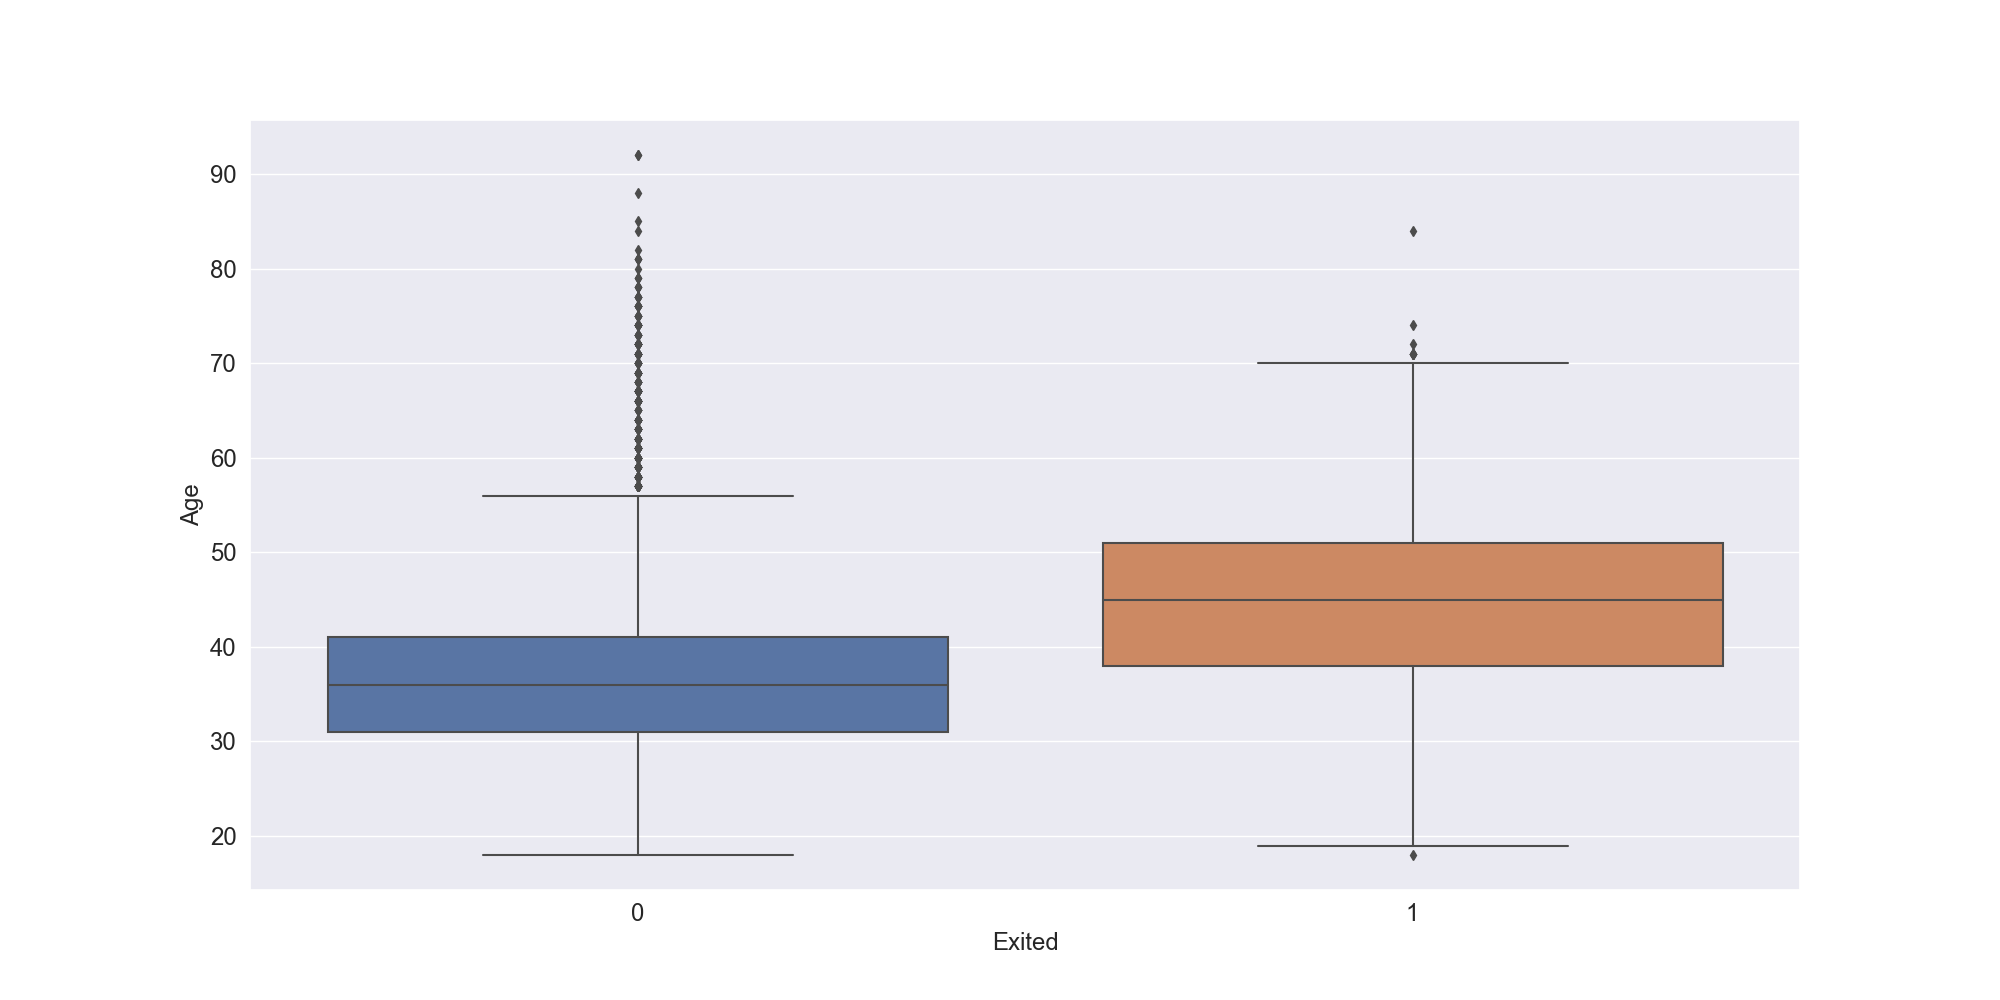
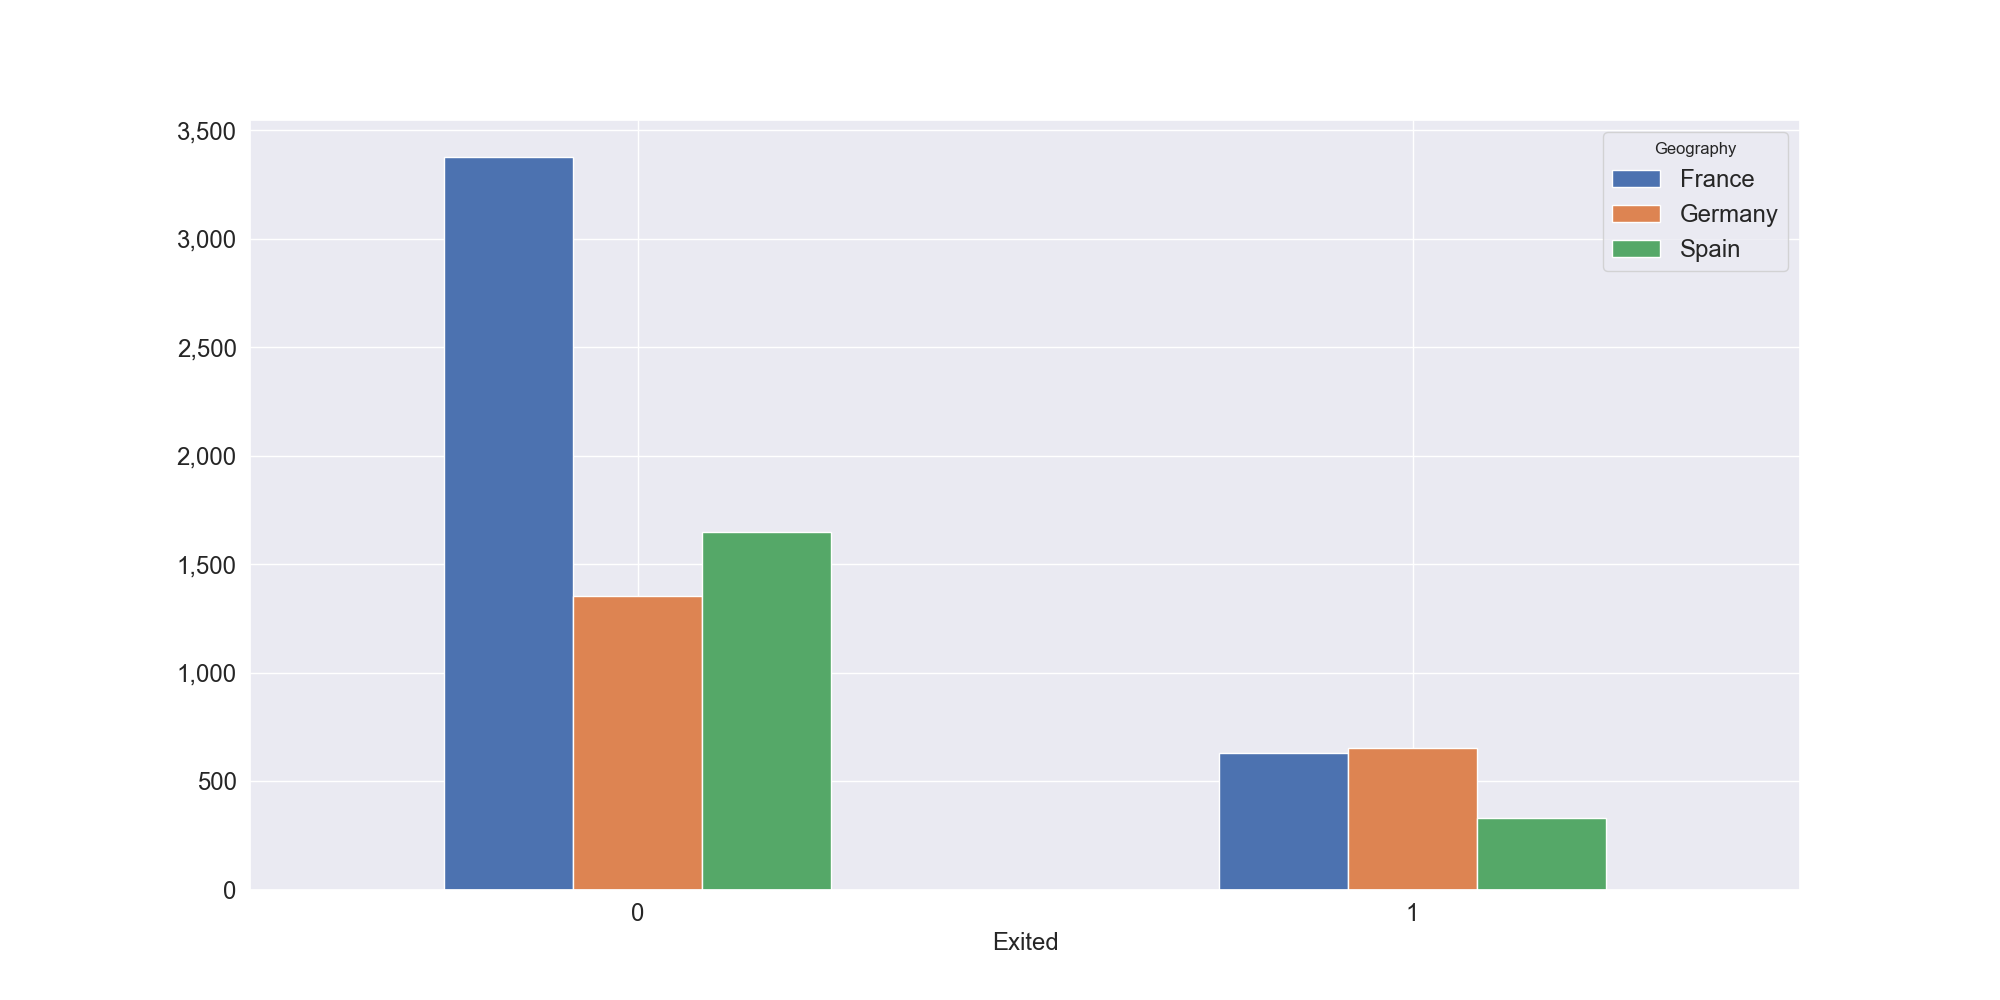
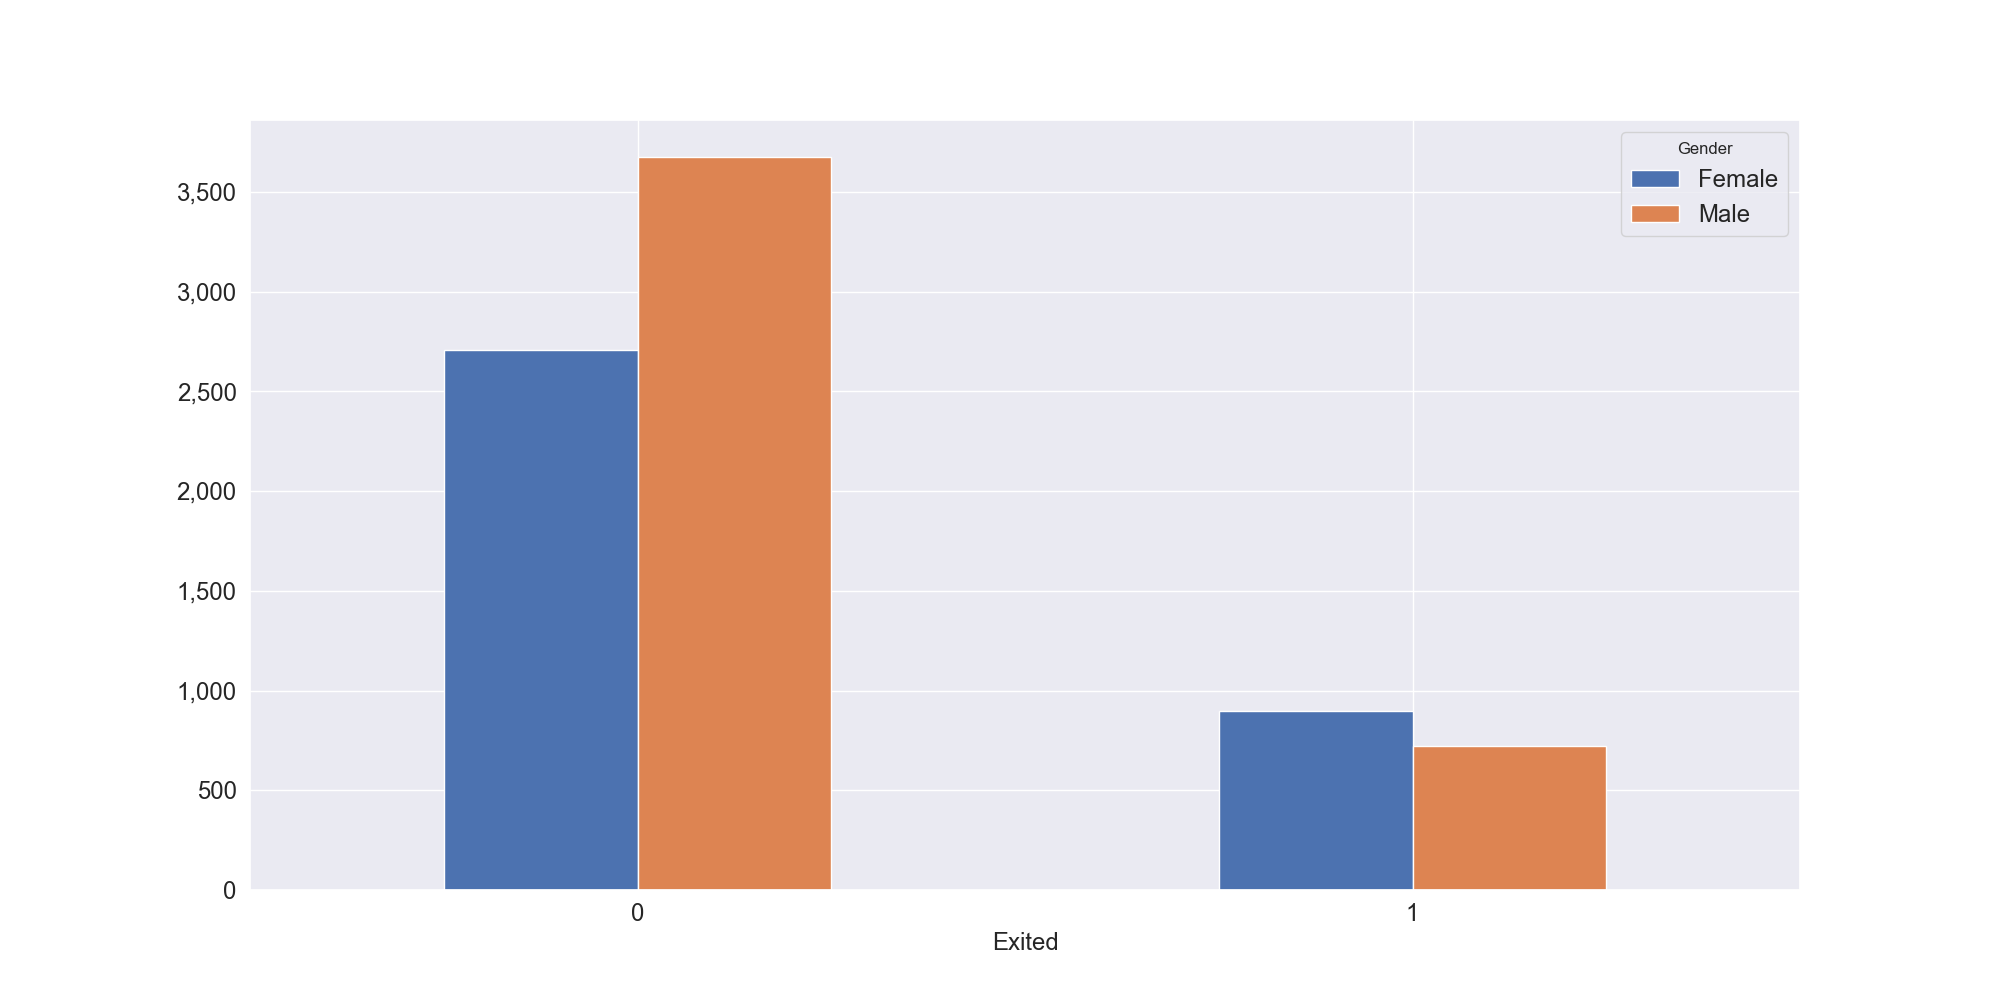
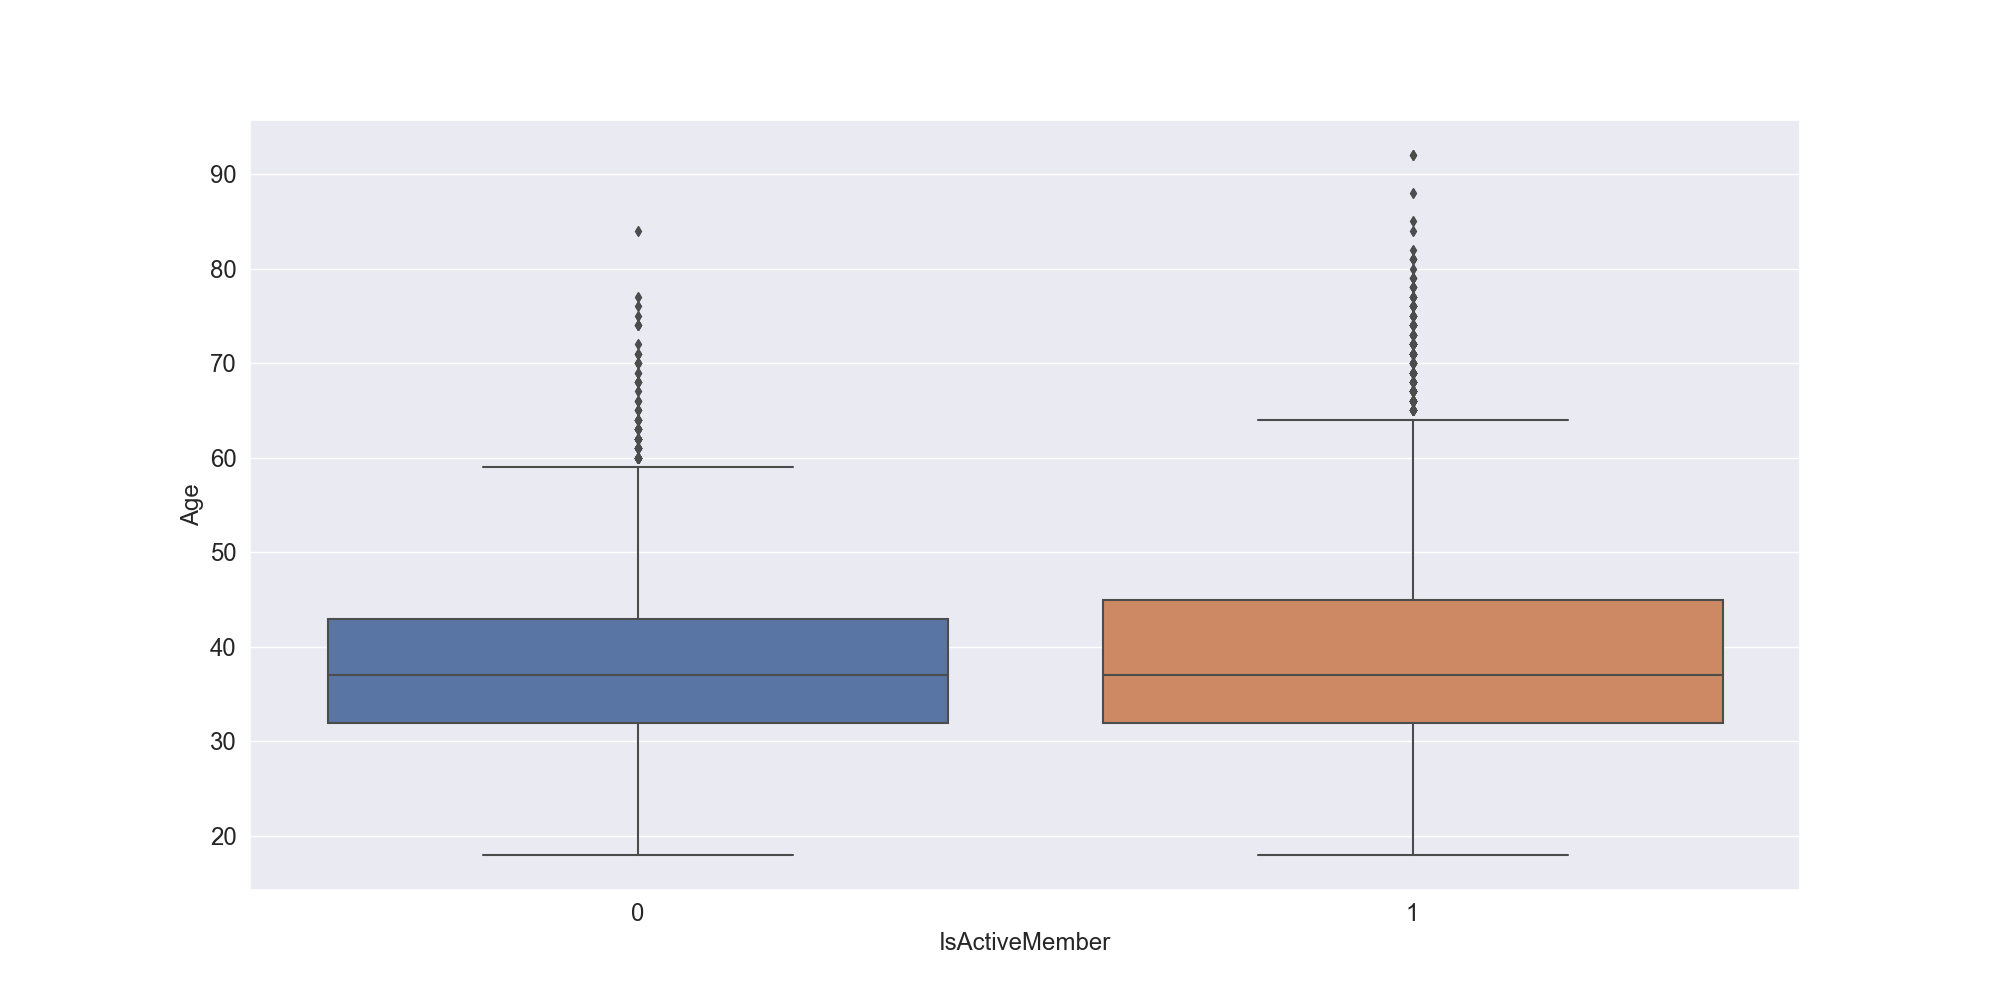
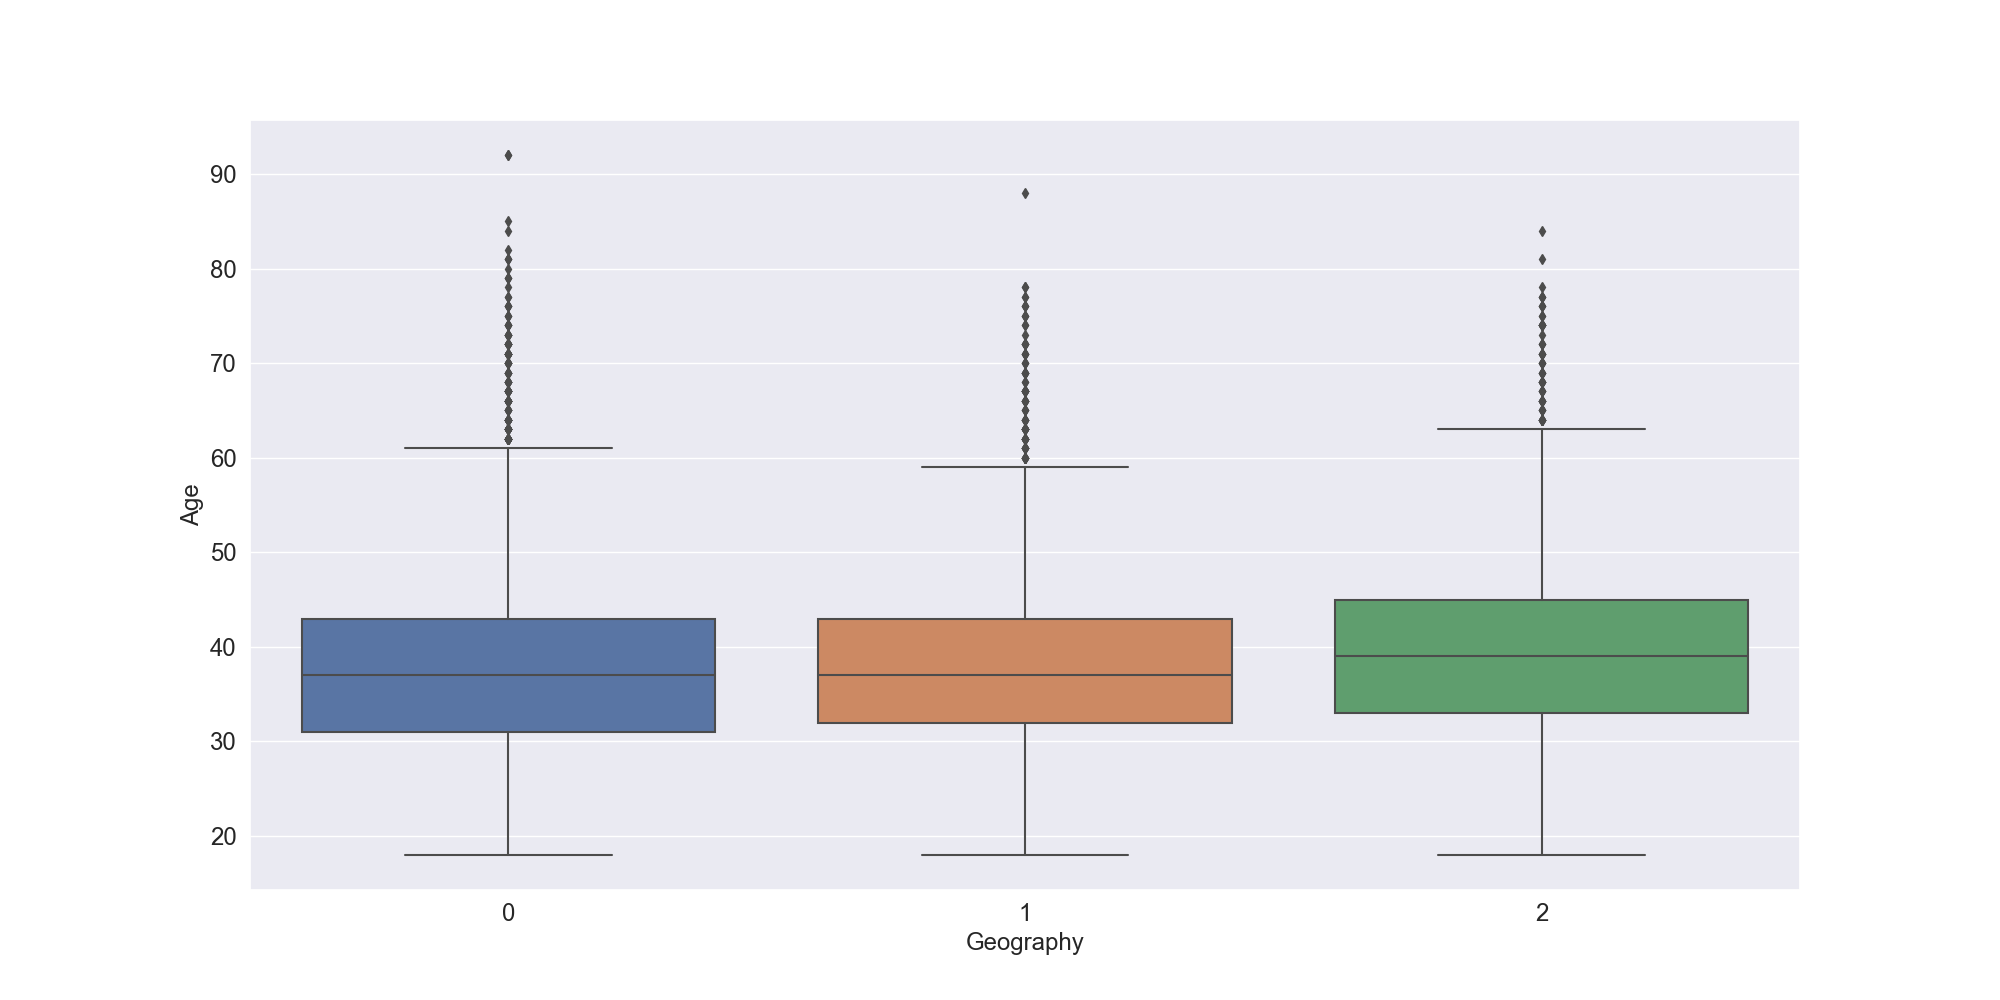
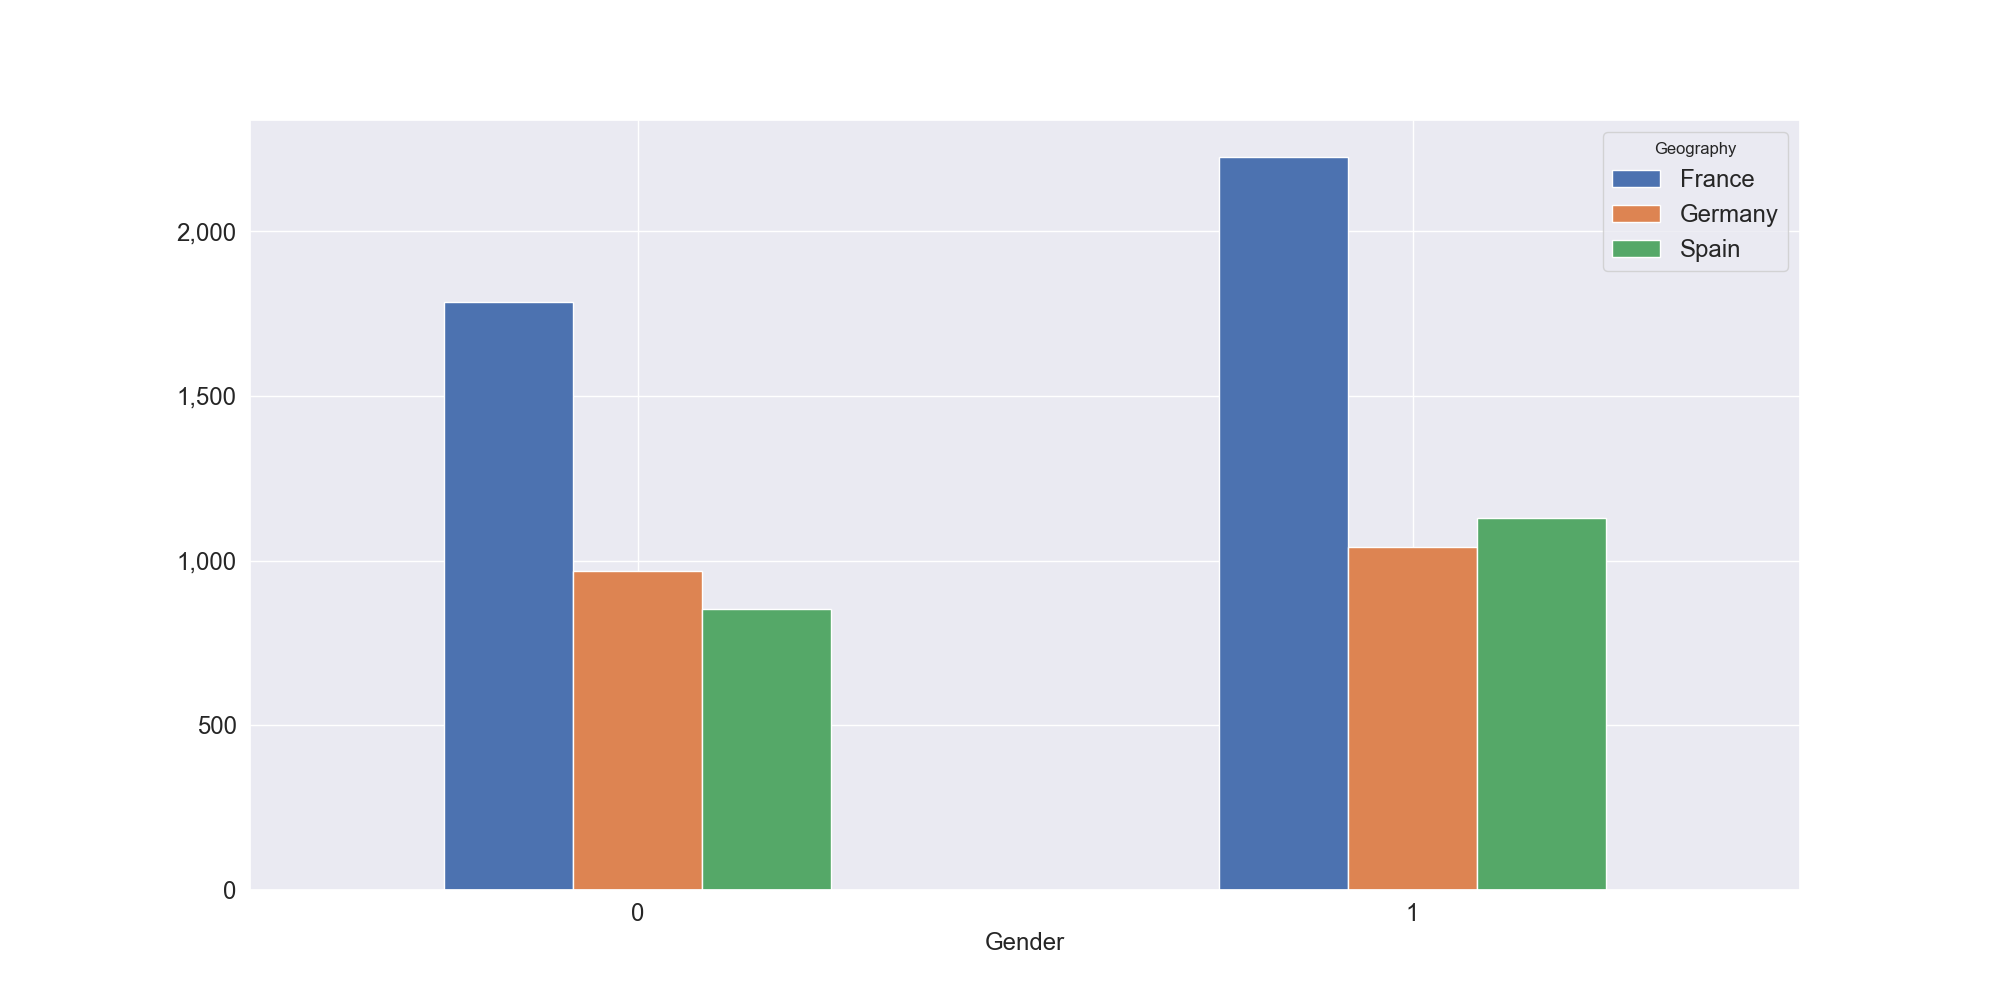
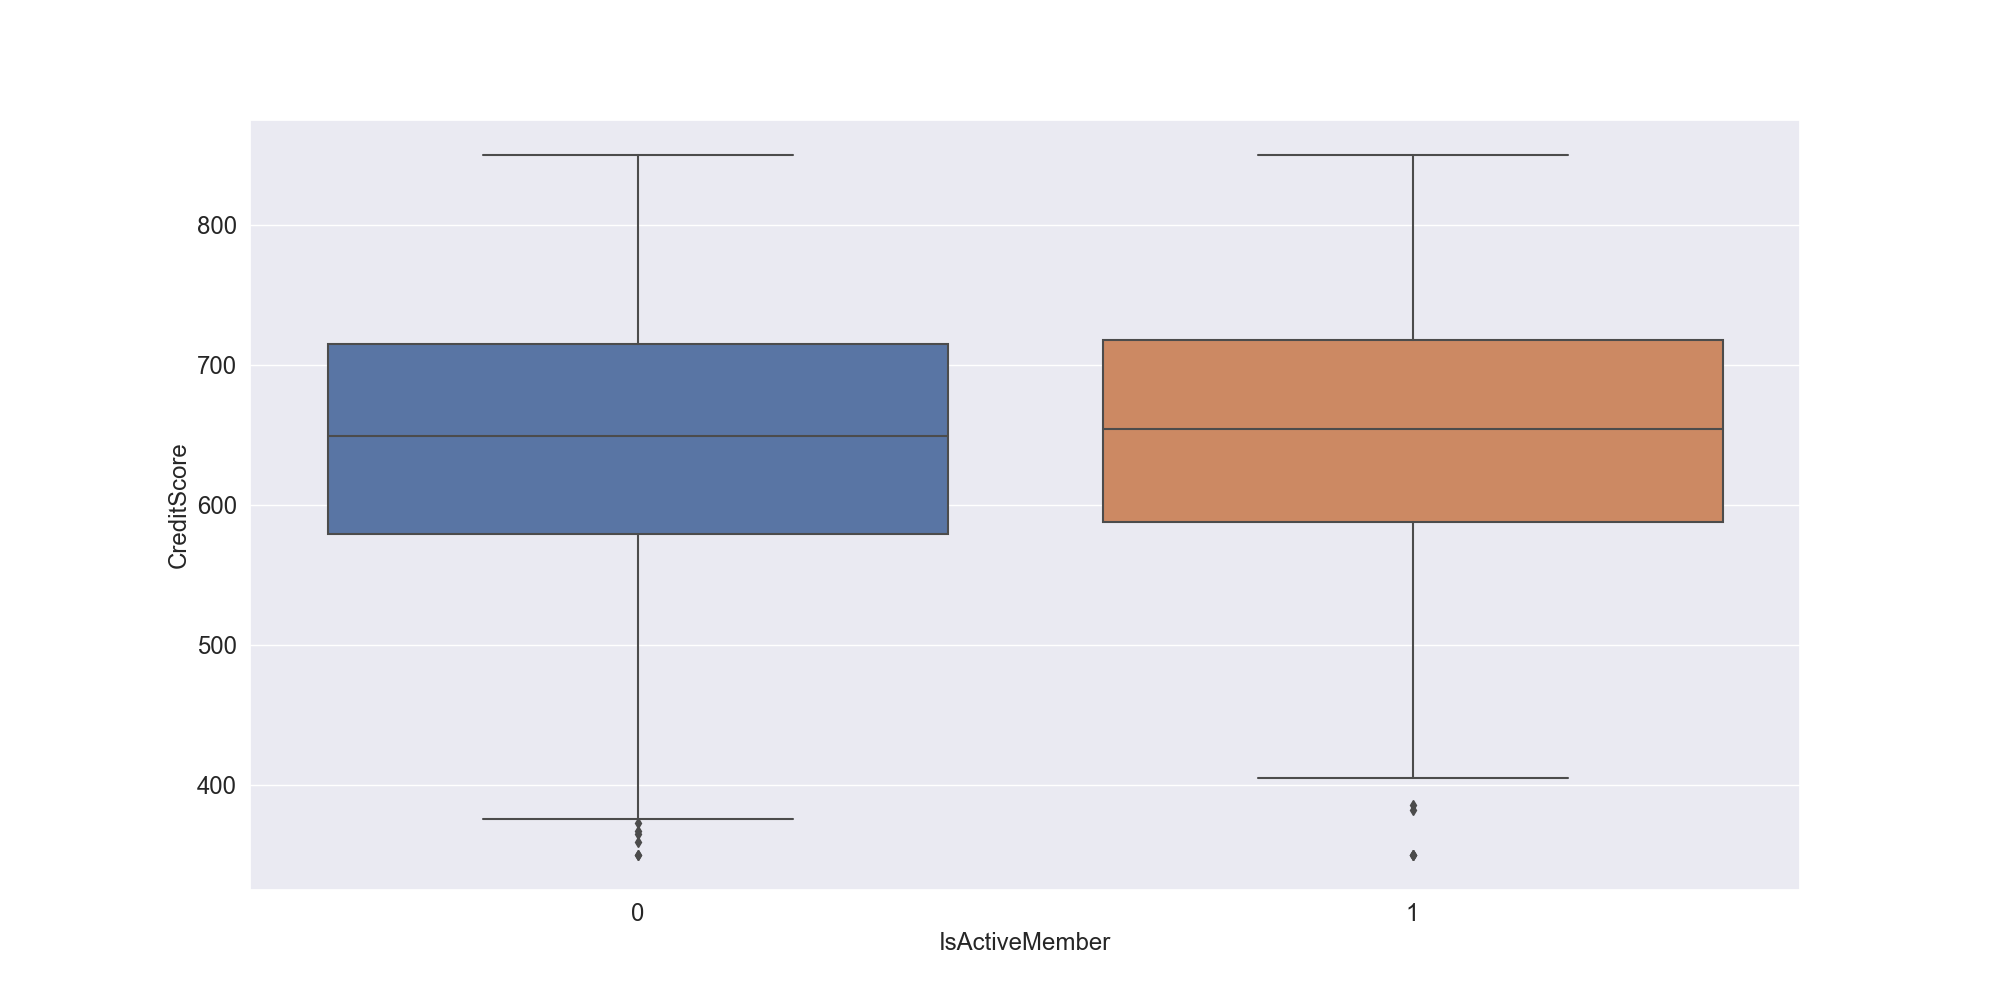
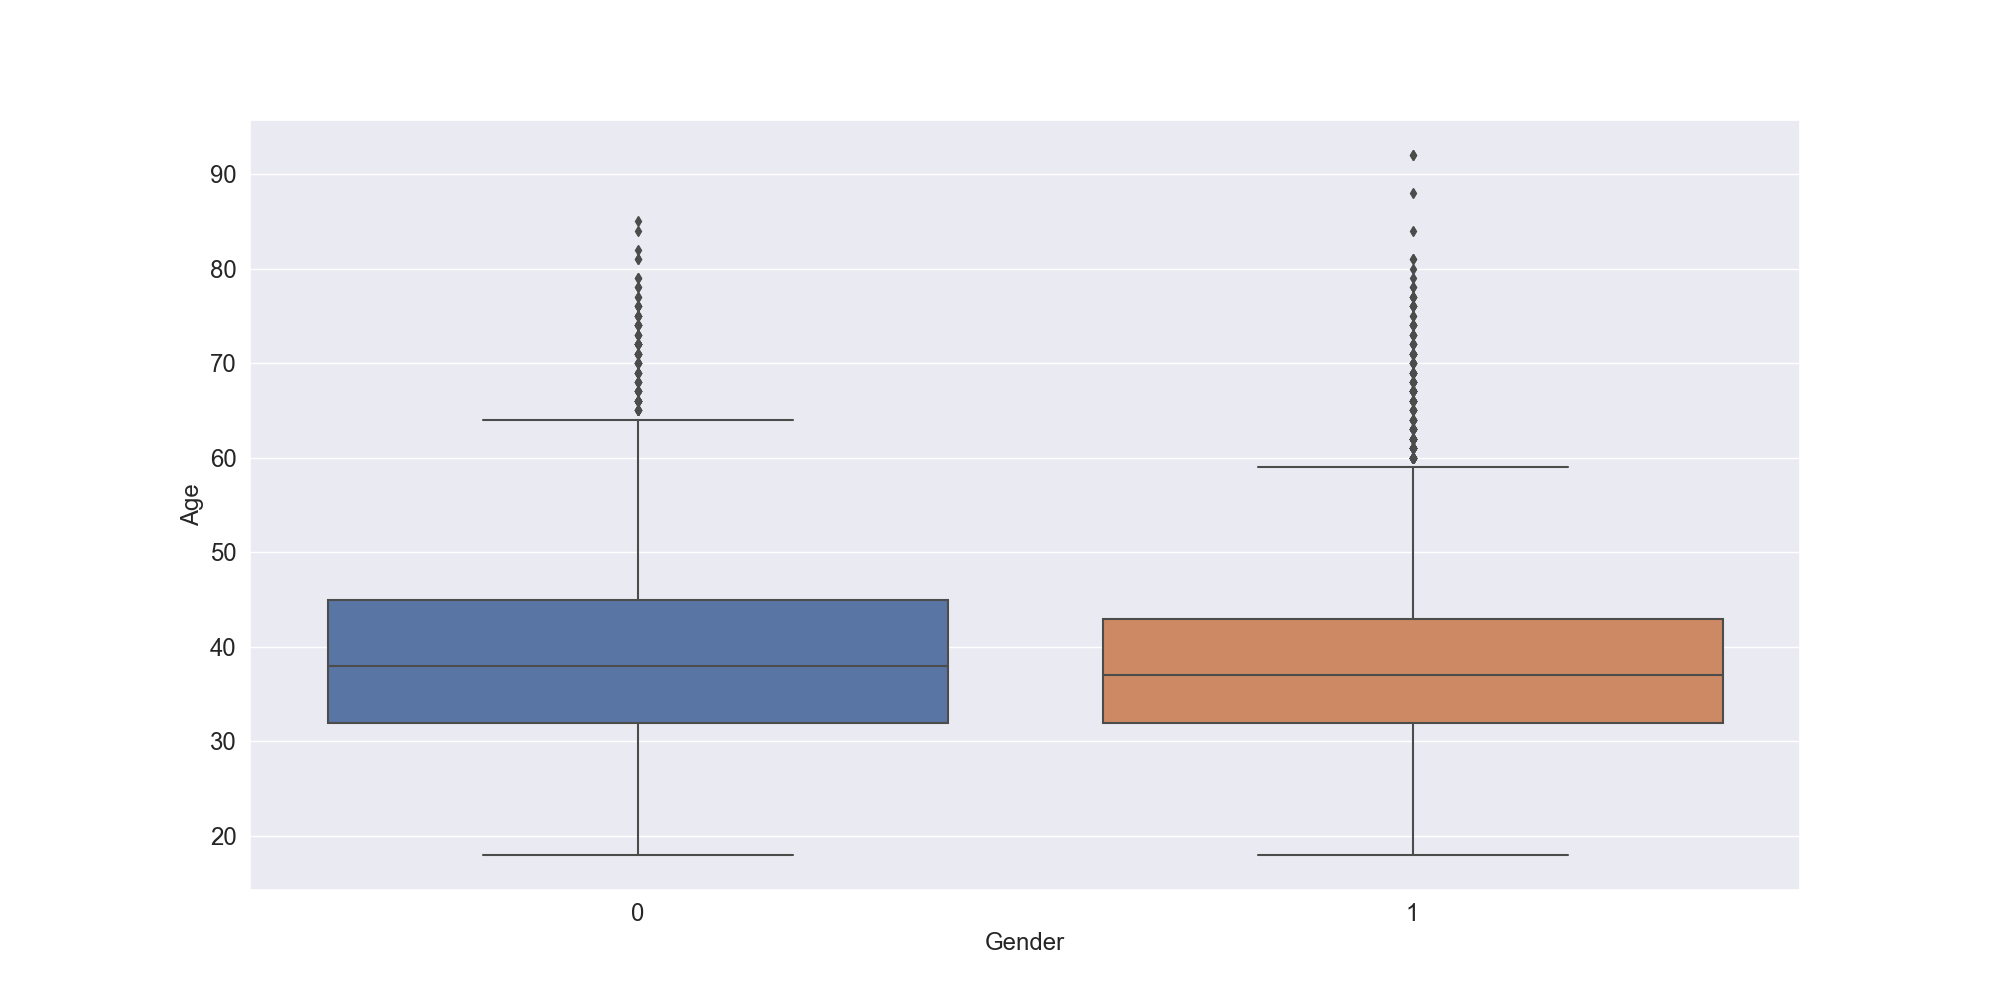
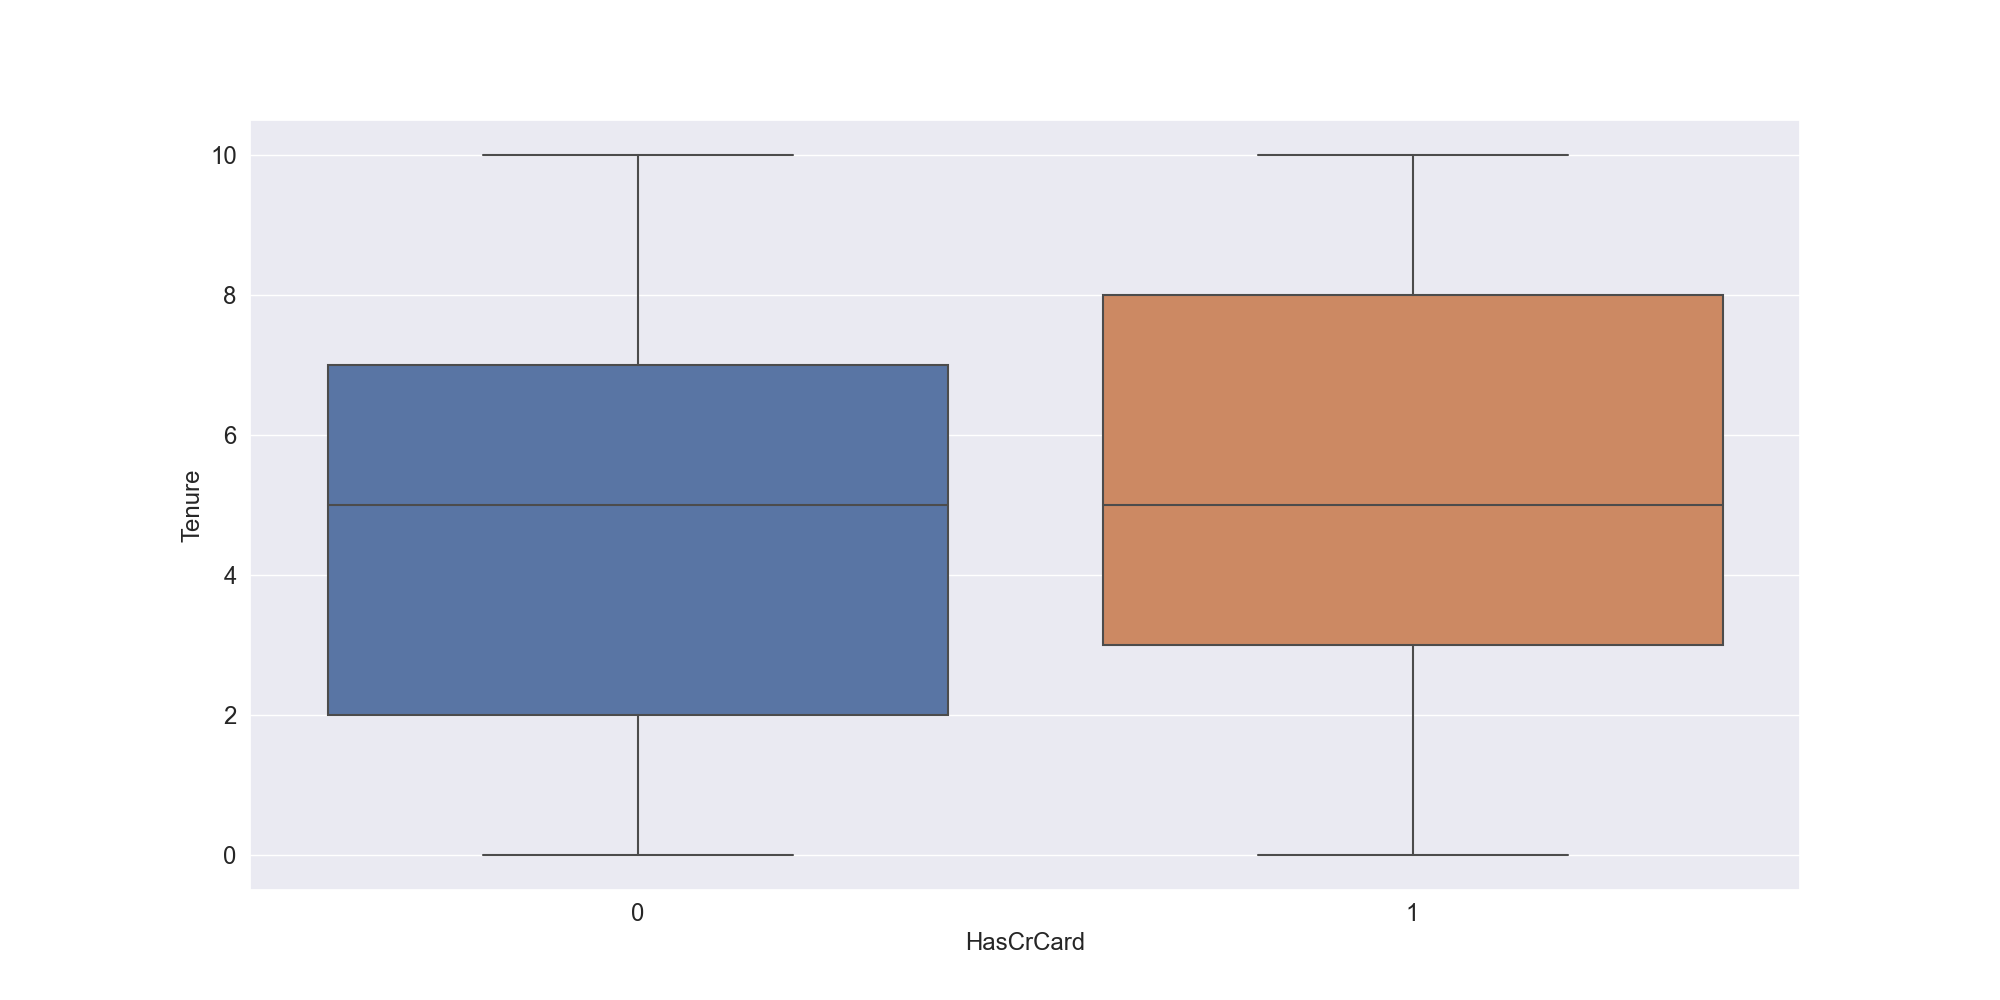
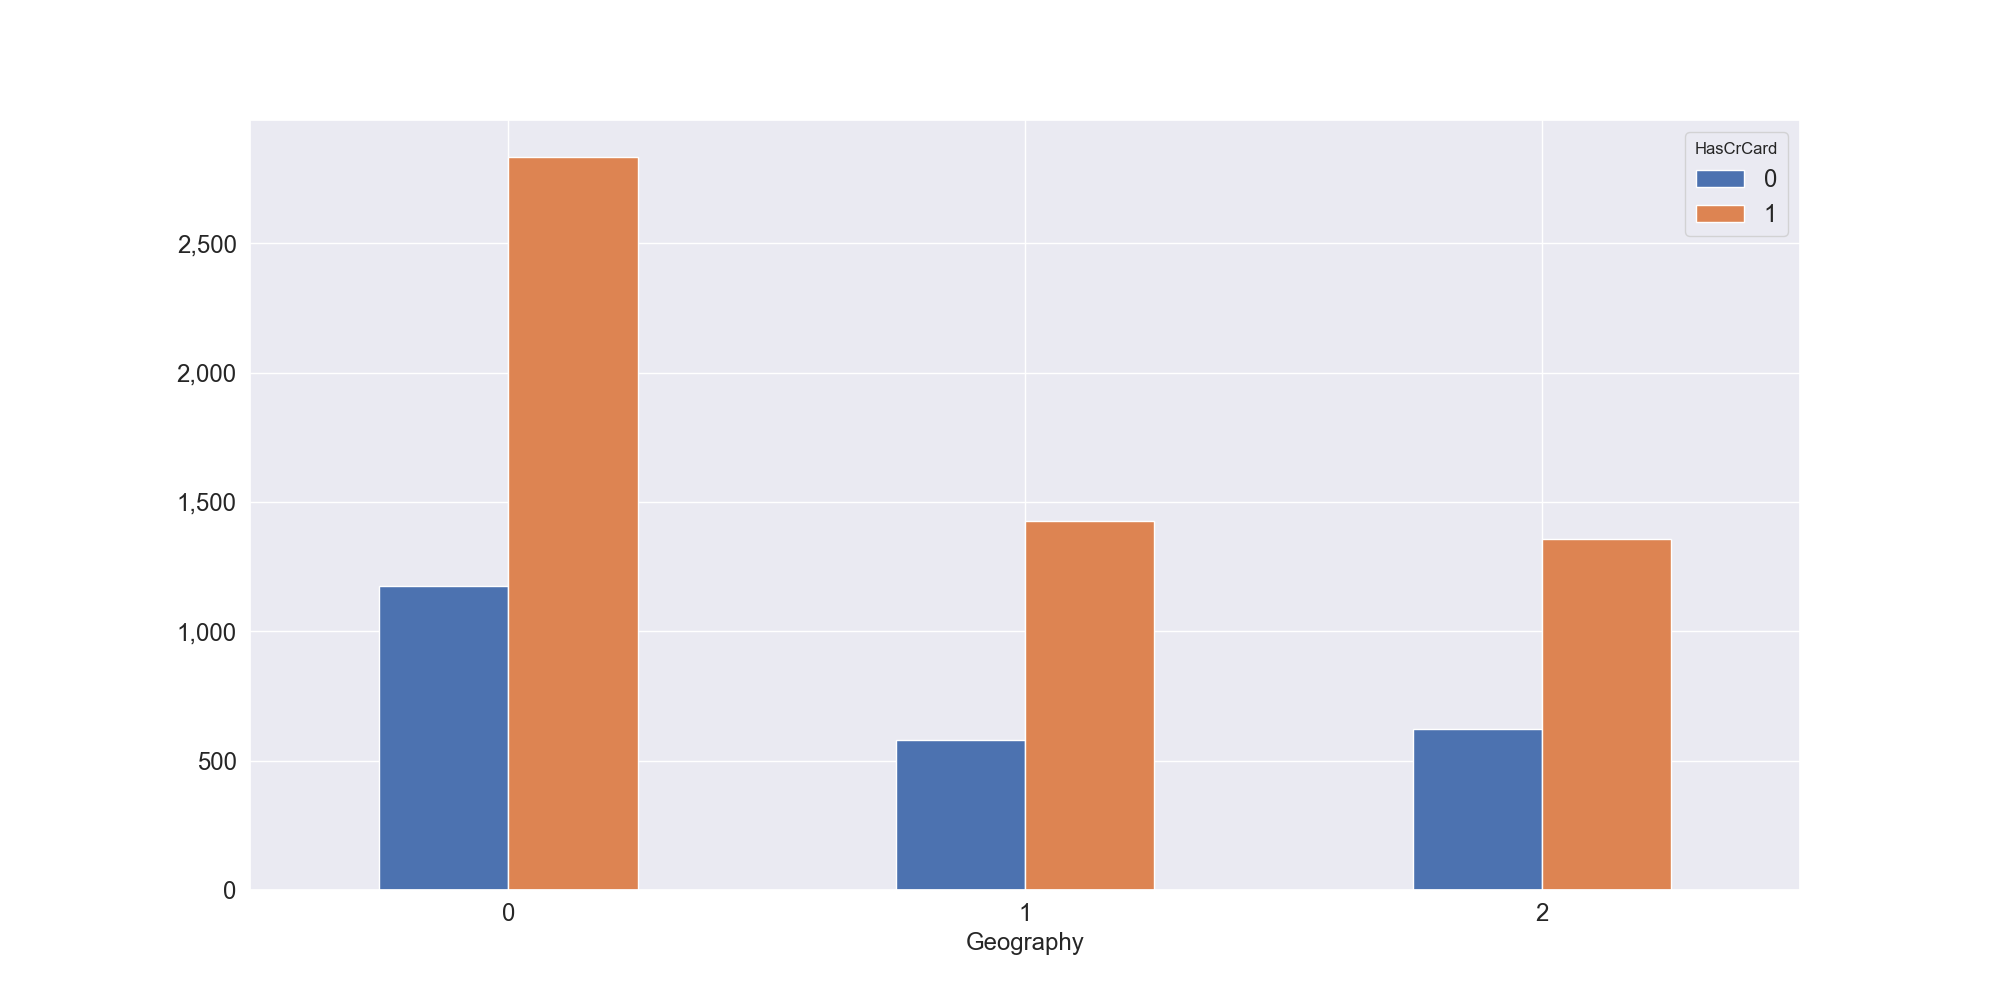
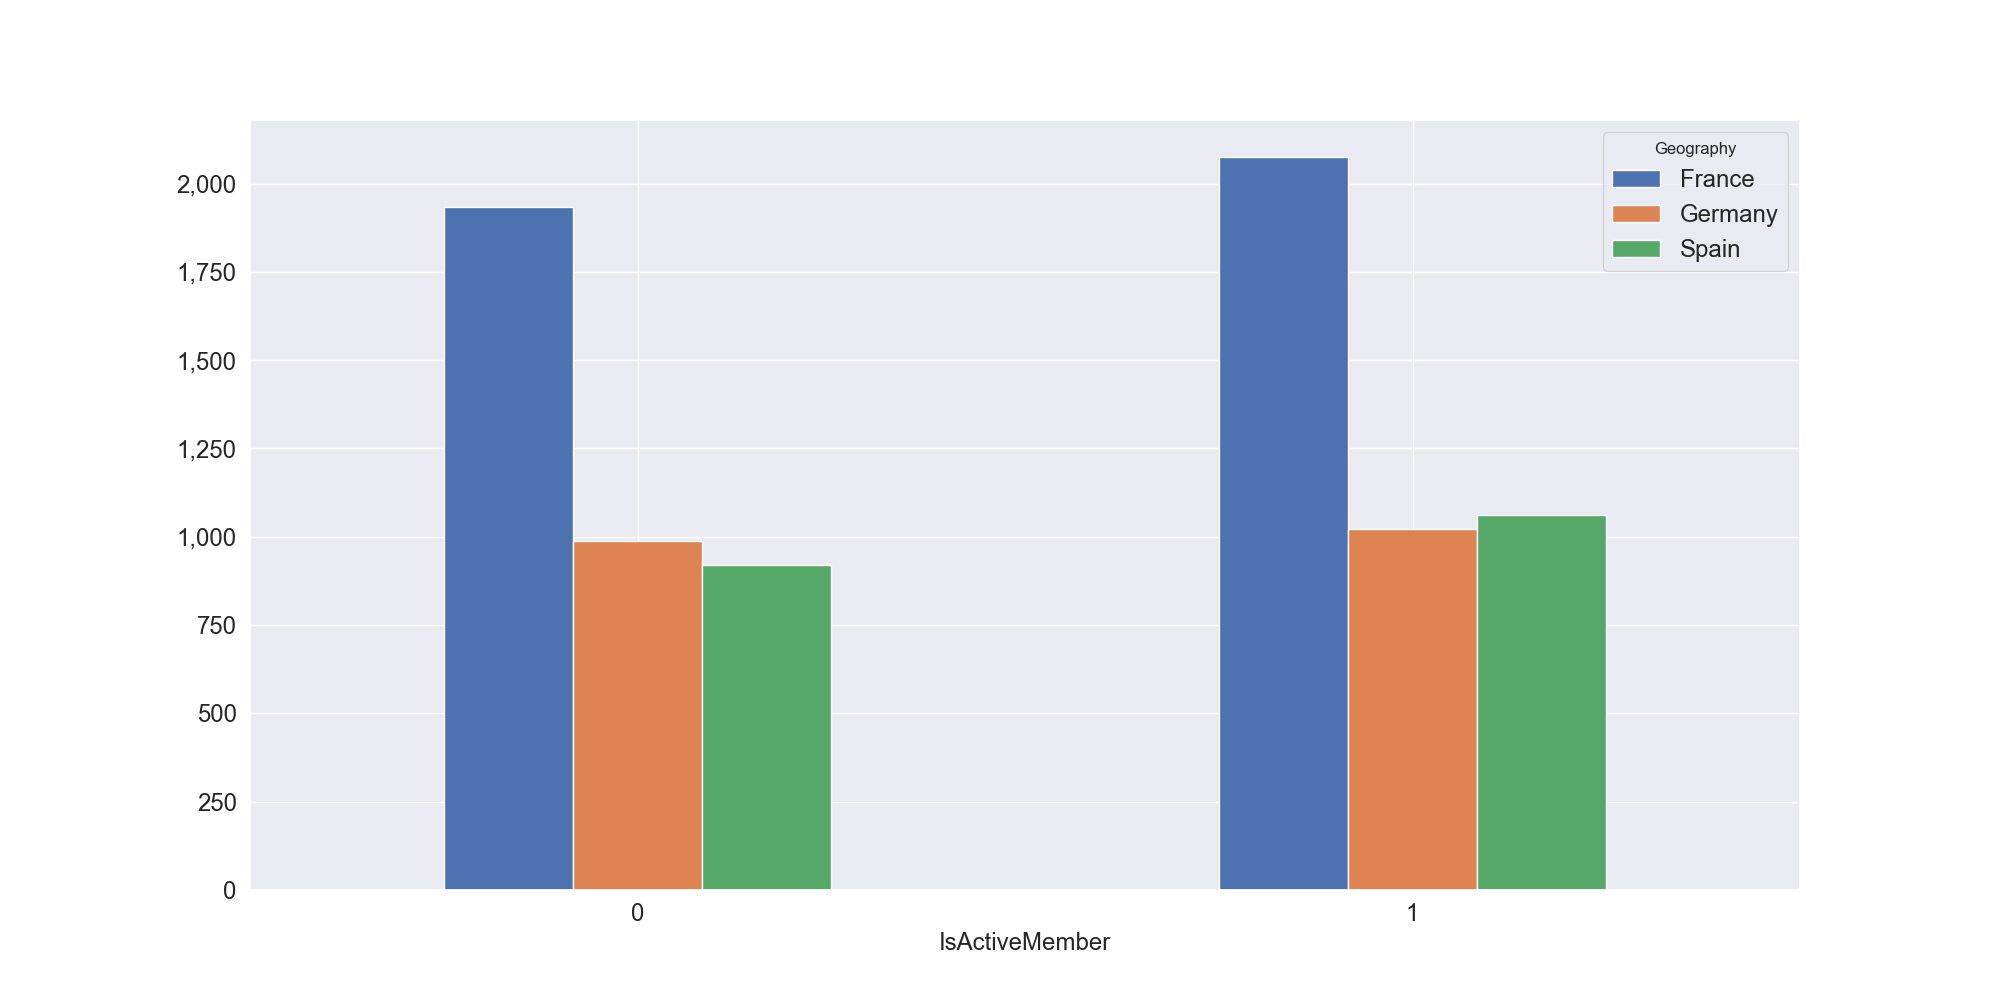
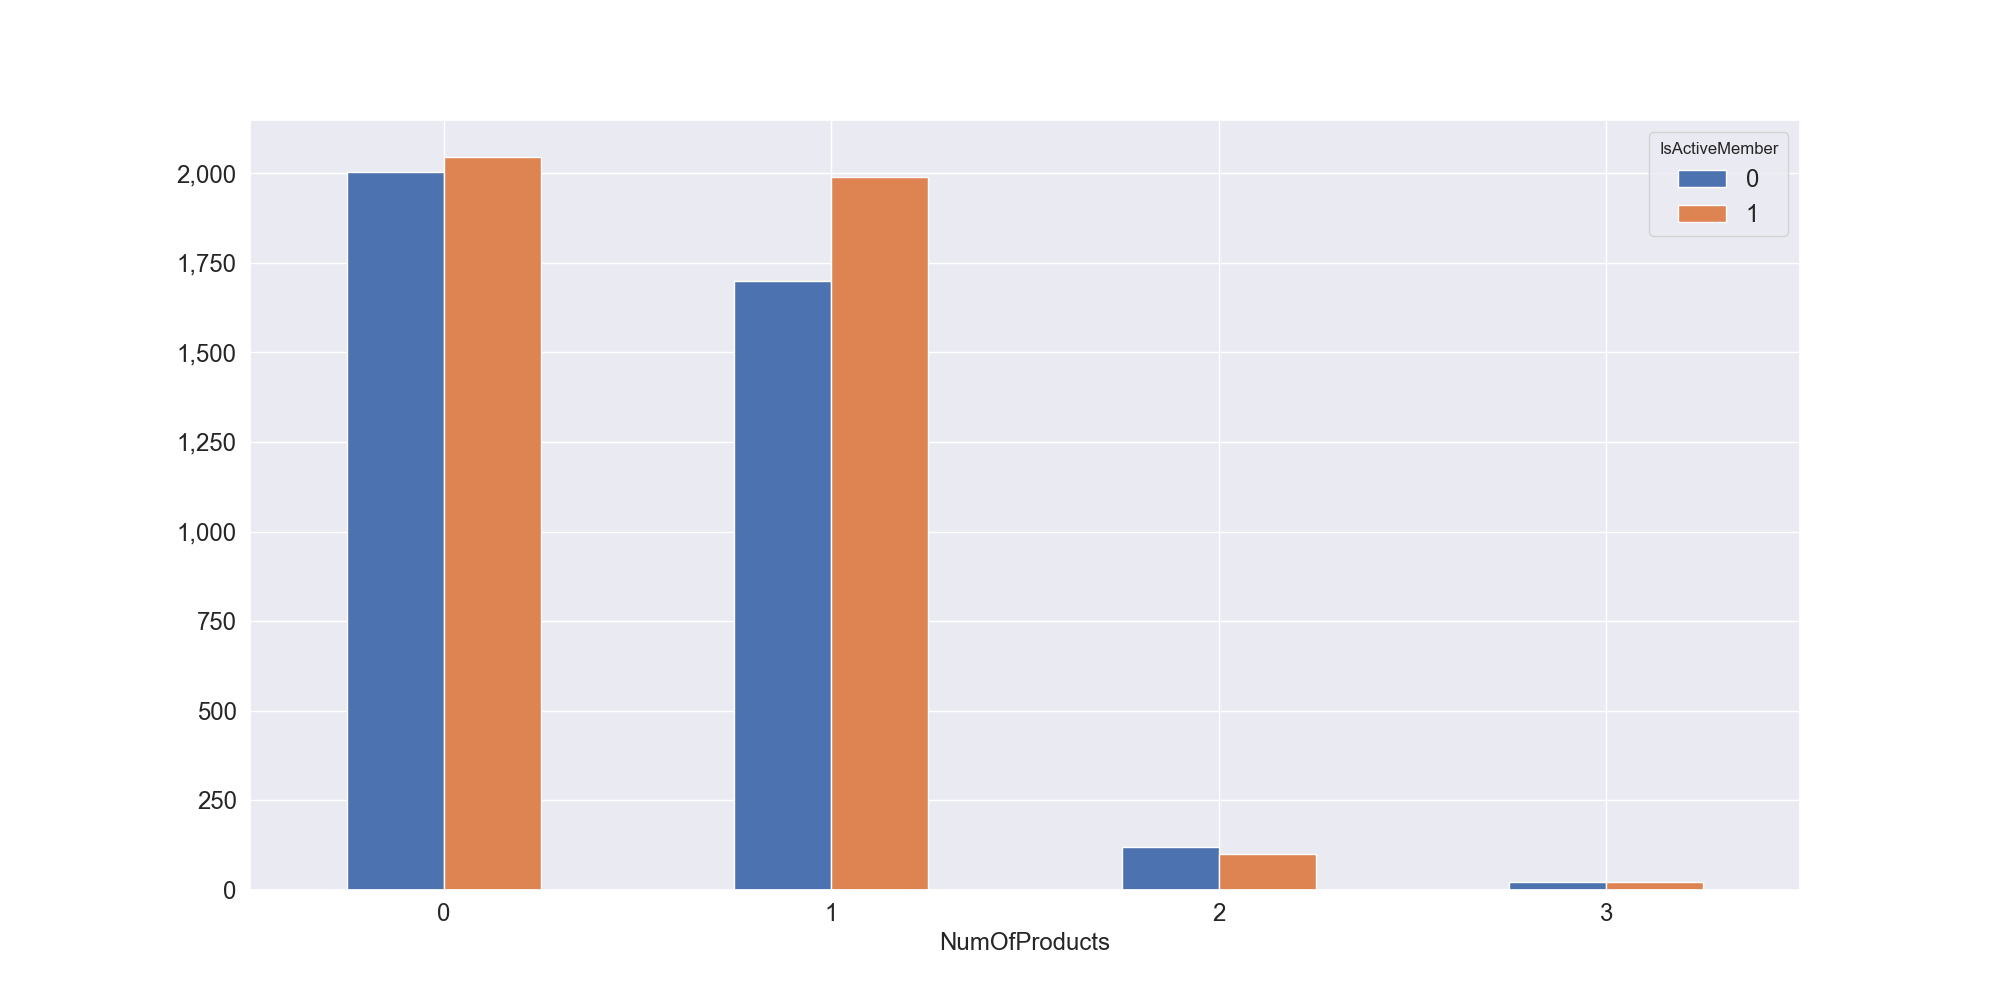
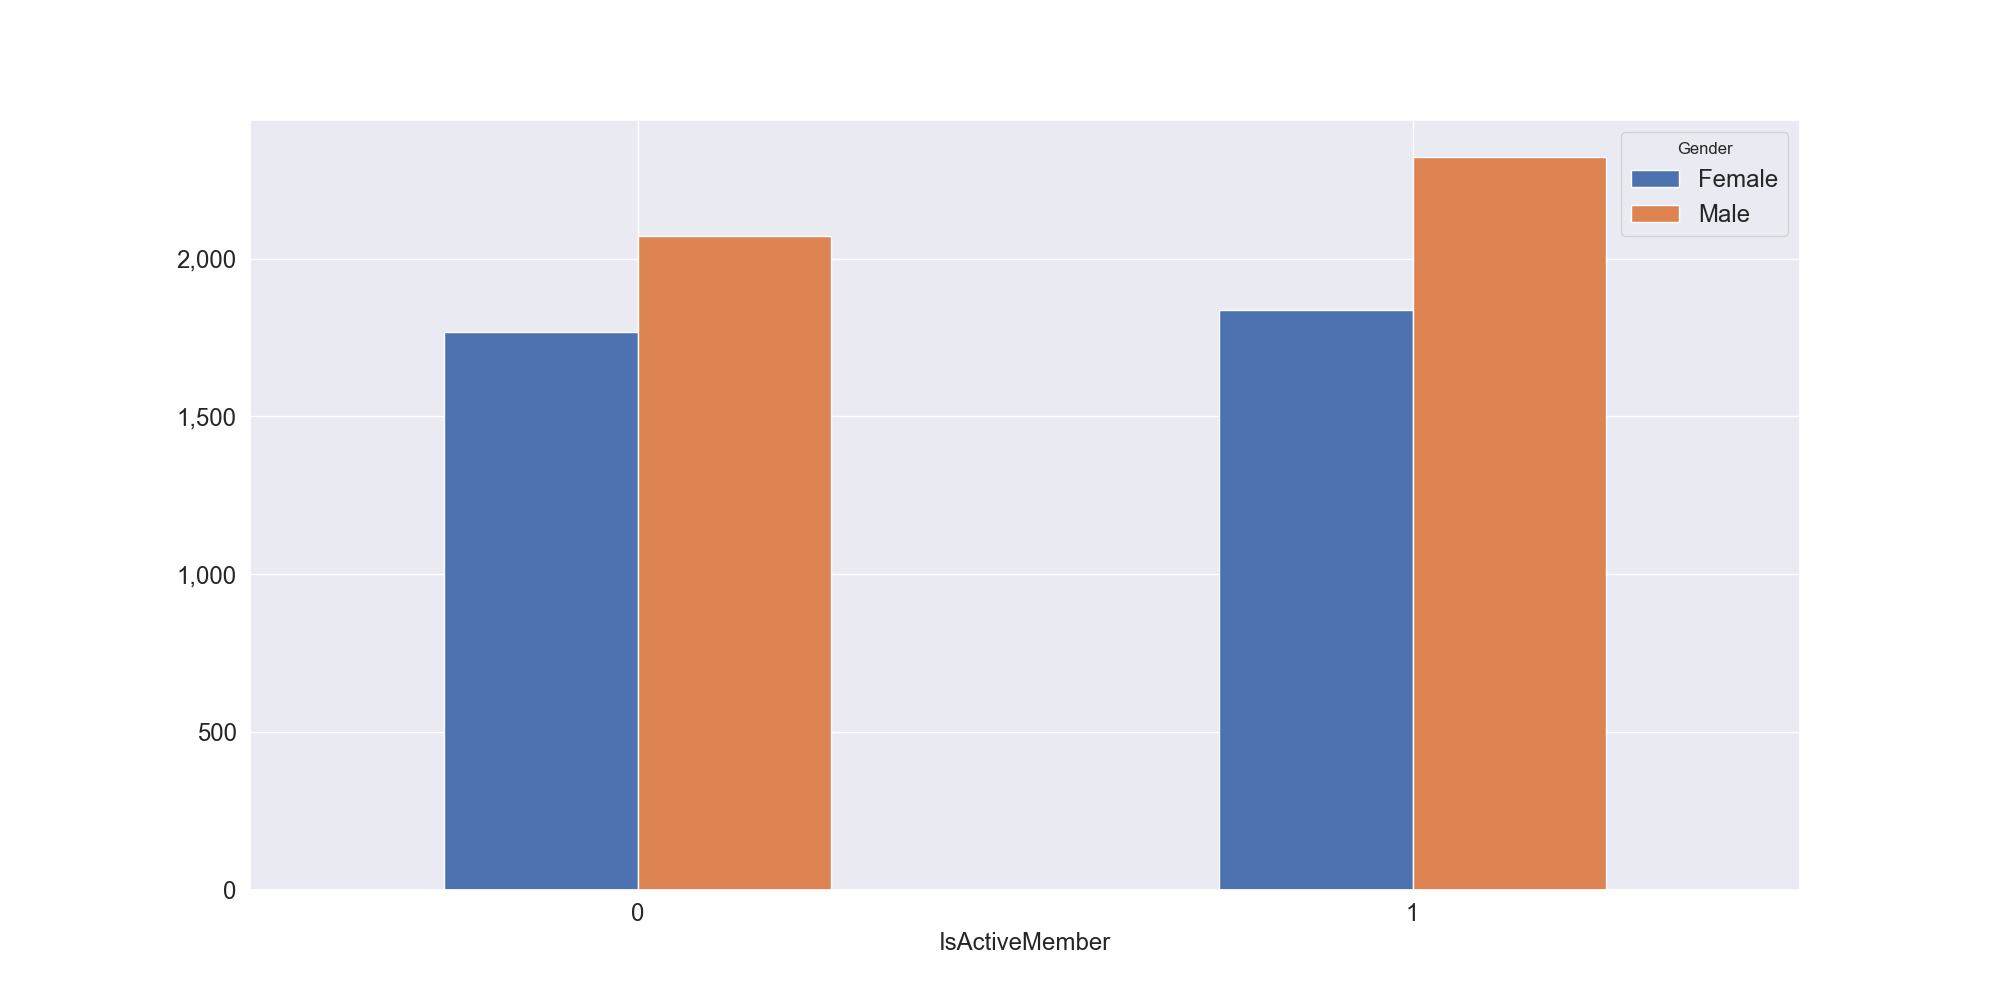
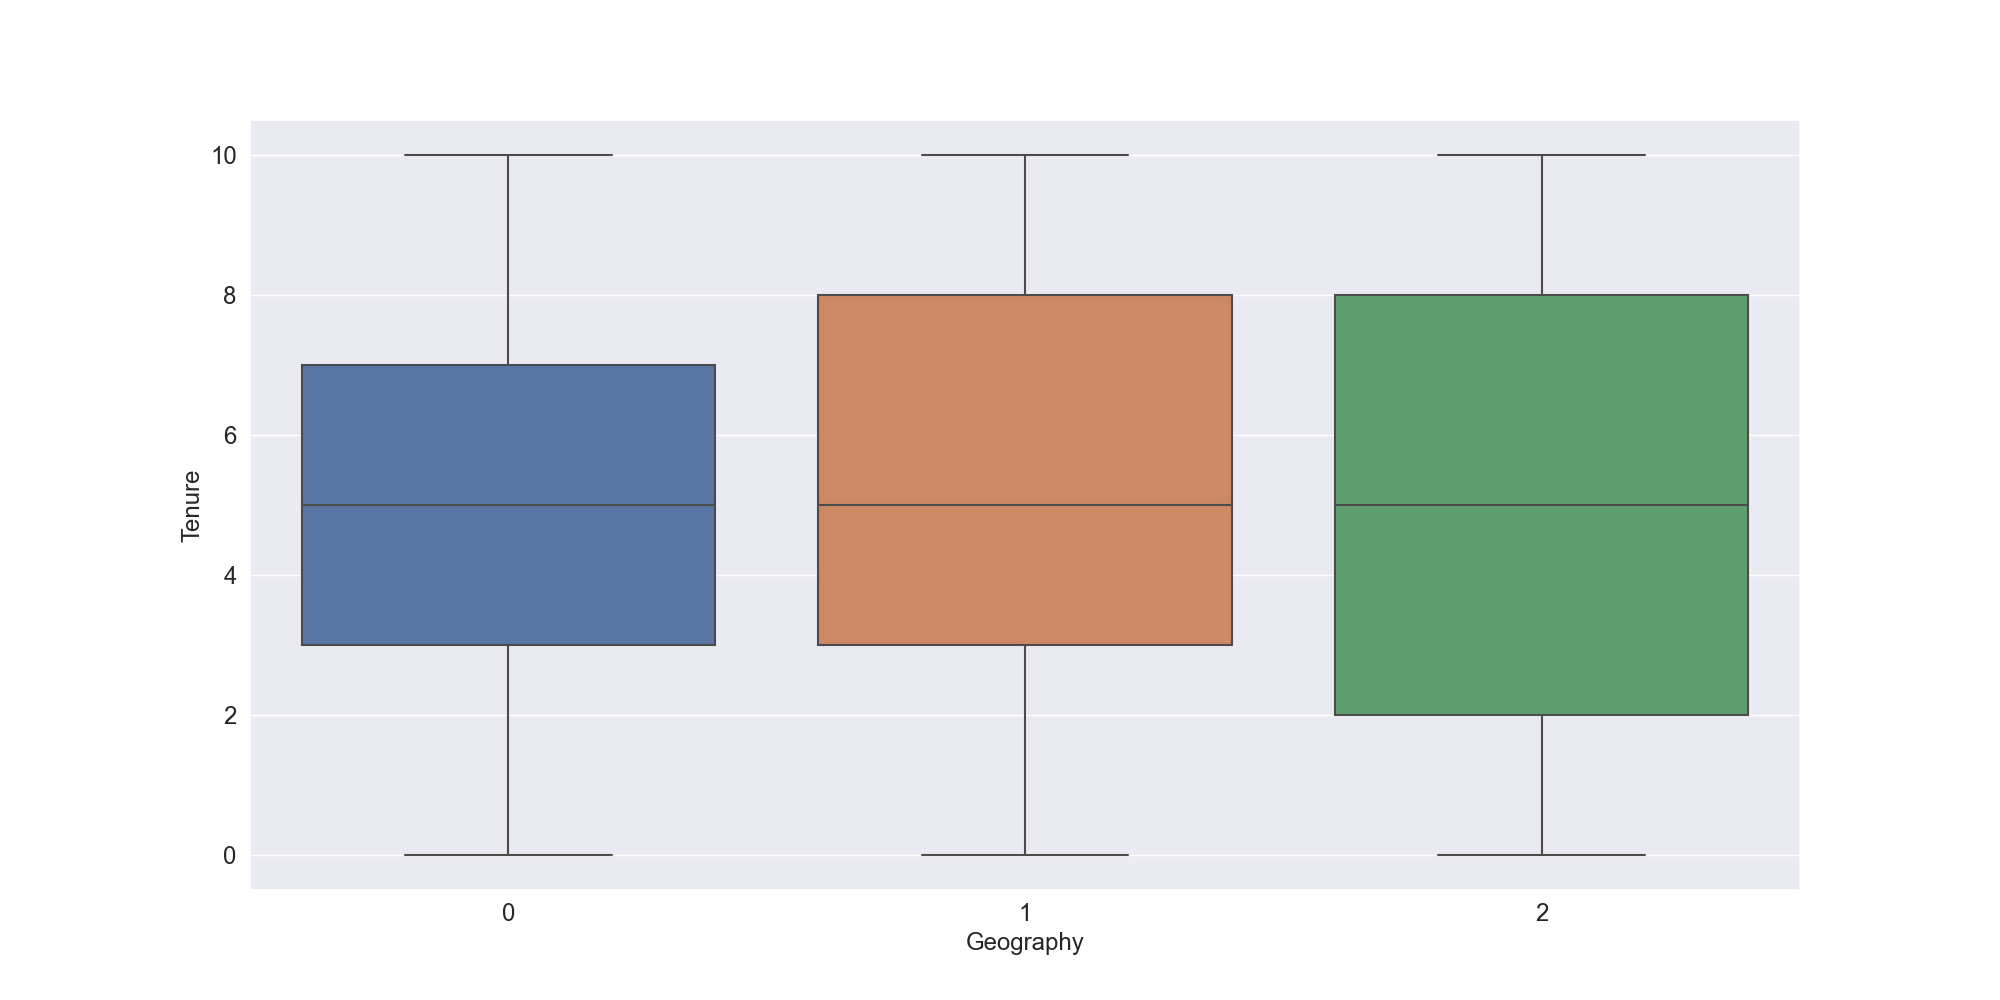
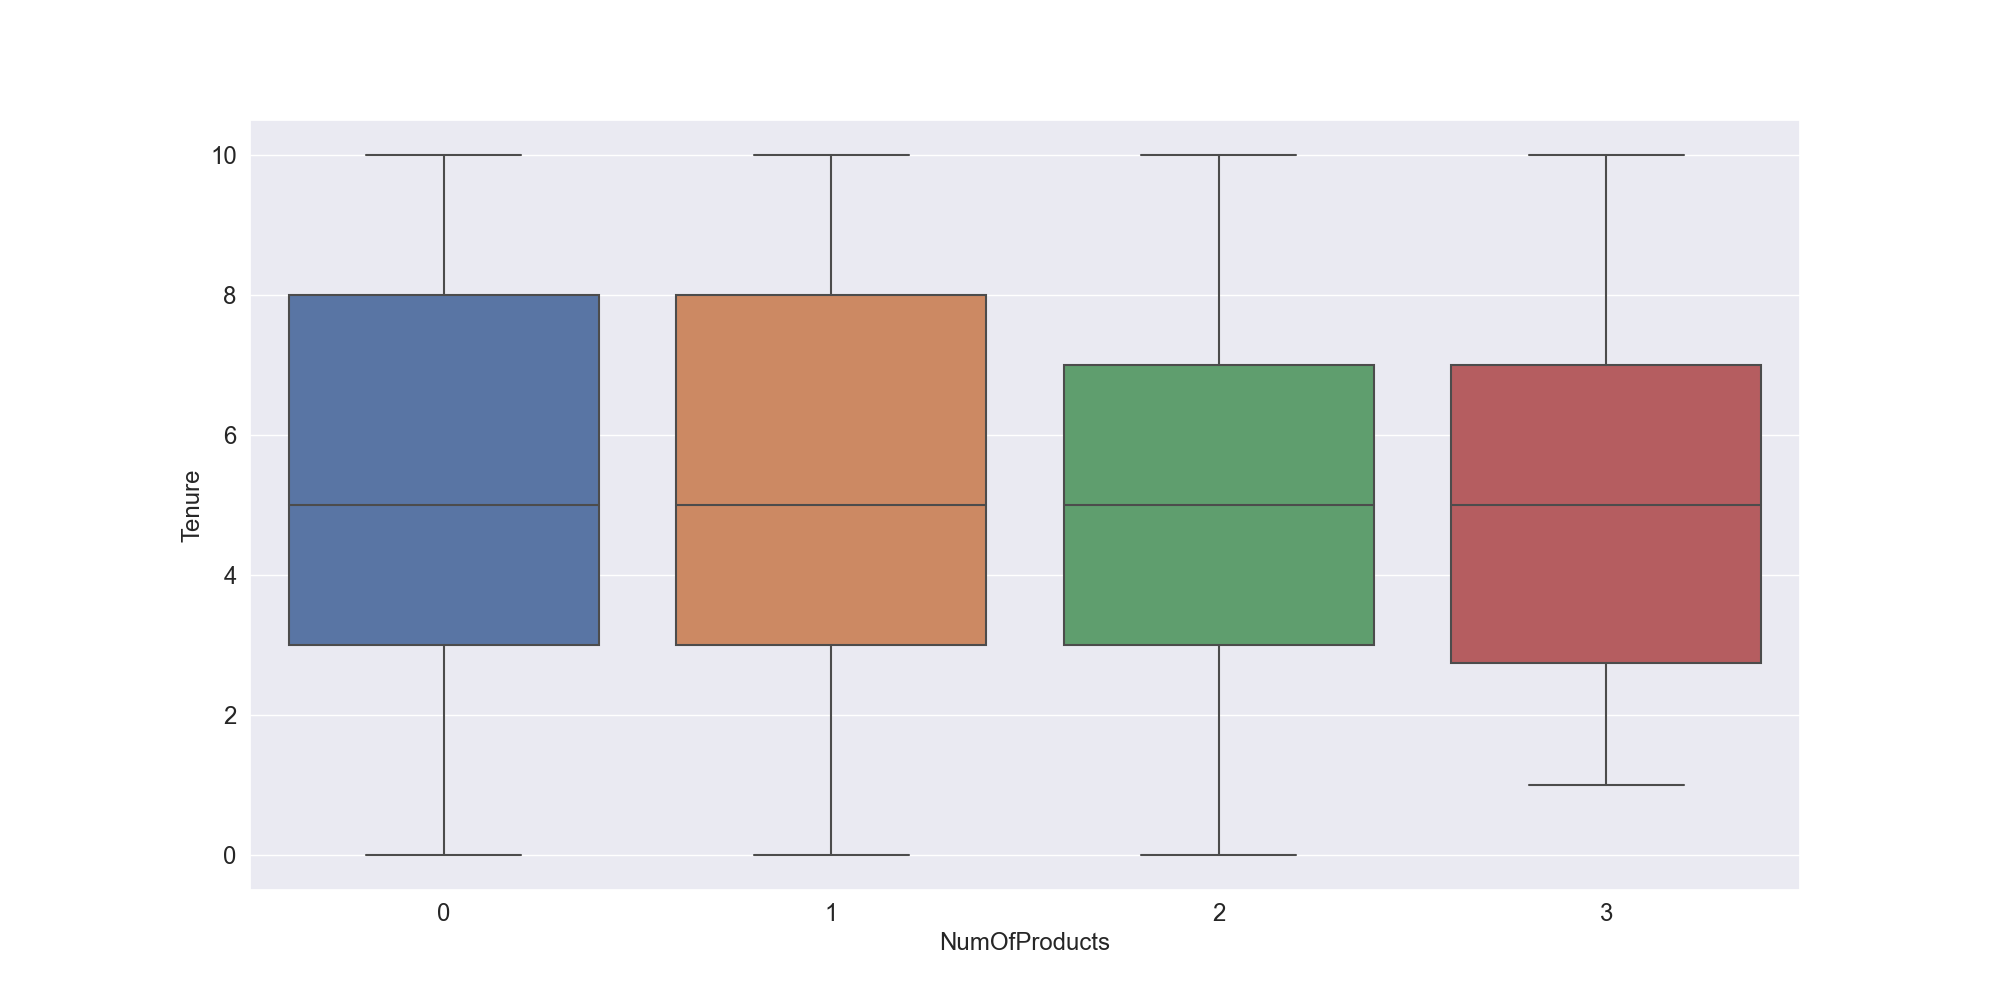

In [3]:
vm.run_test_plan("tabular_dataset", dataset=vm_dataset, send=False)

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)
genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)
df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_ds.drop("Exited", axis=1)
y_train = train_ds.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False,
)

y_pred = model.predict_proba(x_val)[:, -1]
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.855625


In [5]:
vm_model = vm.init_model(model)
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column="Exited")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic", target_column="Exited")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Running SHAPGlobalImportance: shap:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 12/13 [00:00<00:00, 42.82it/s]ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



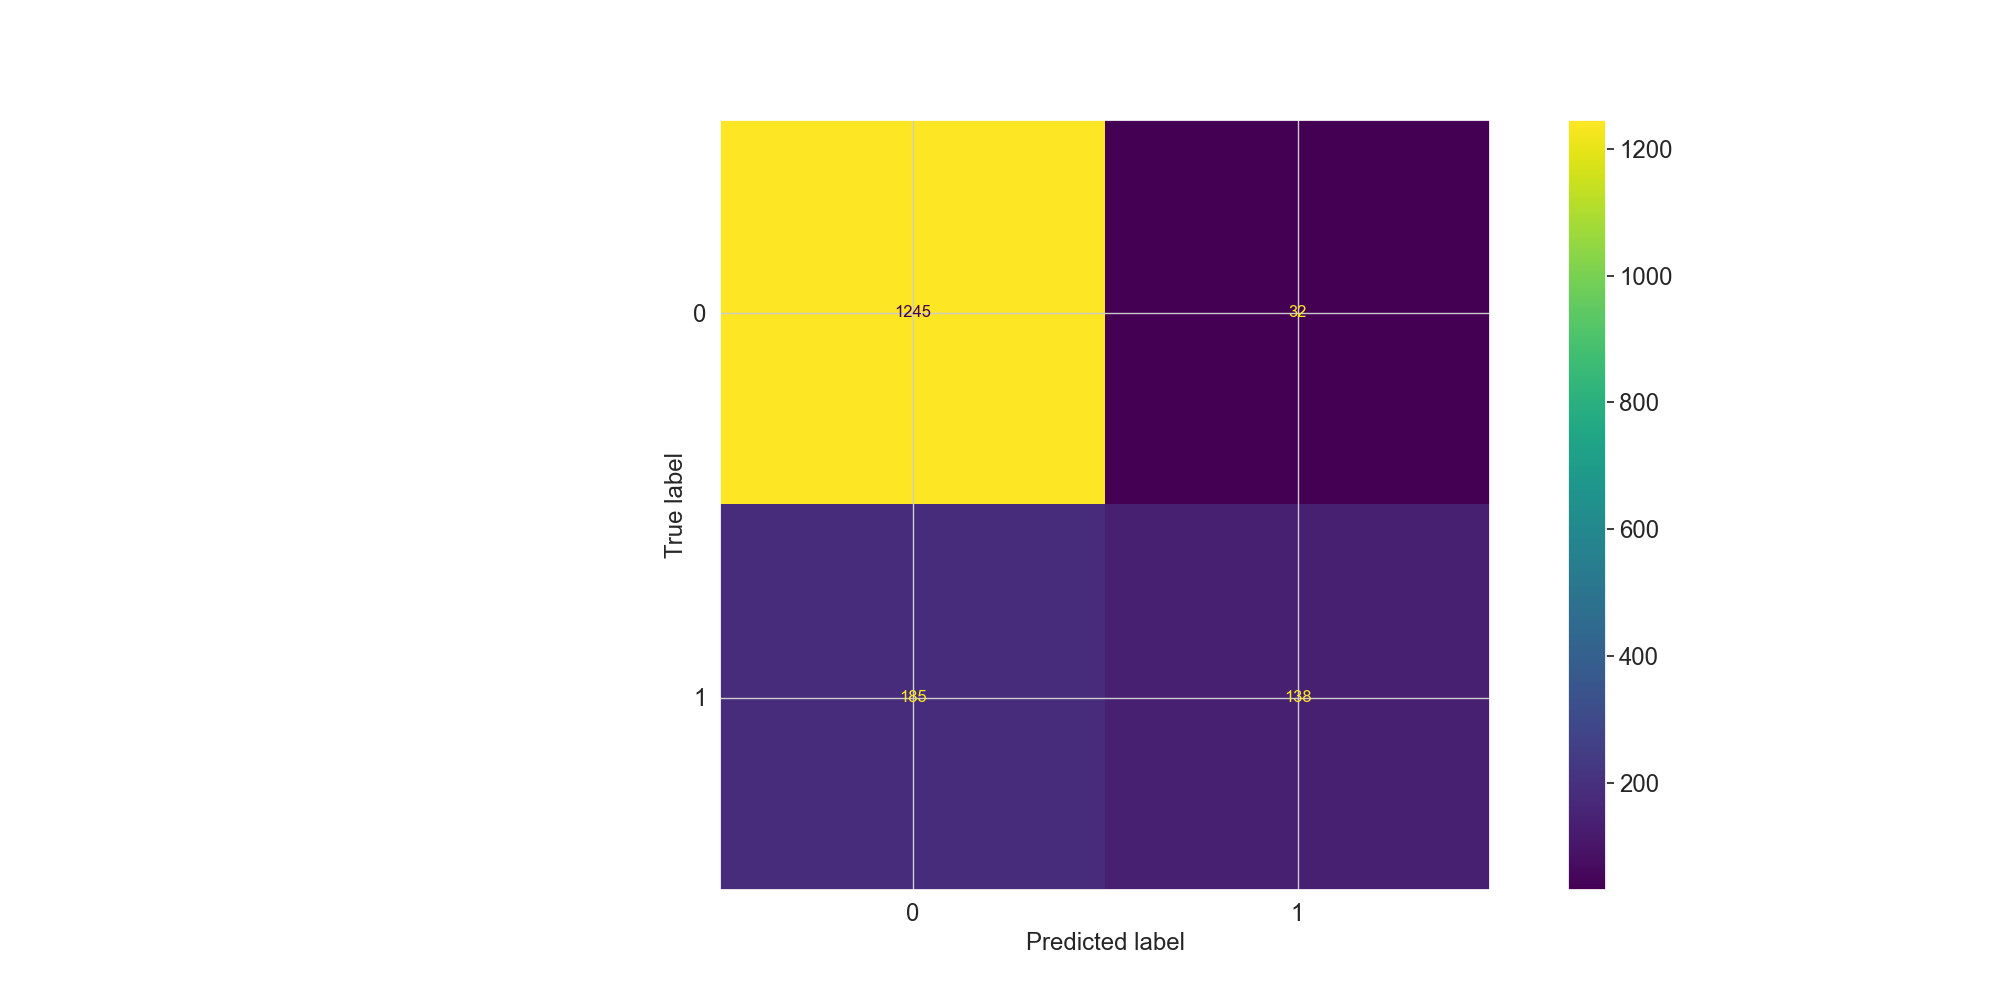
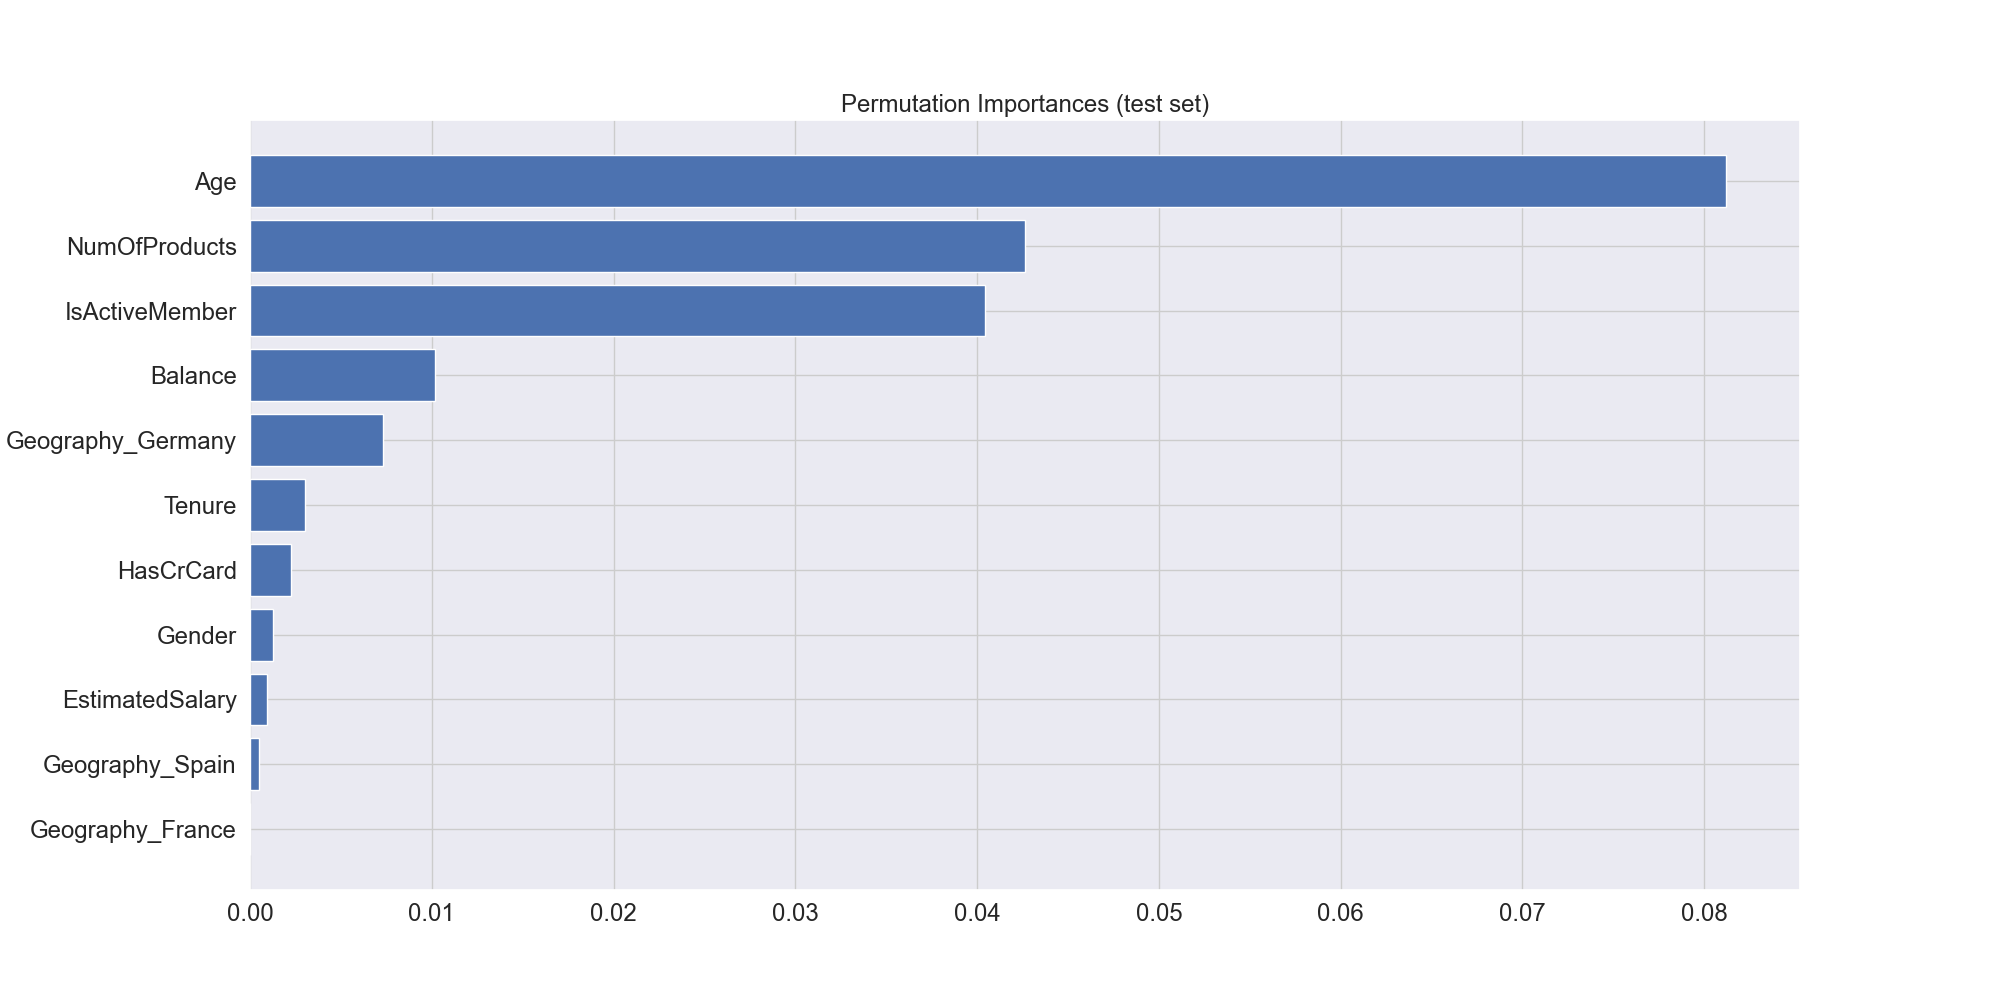
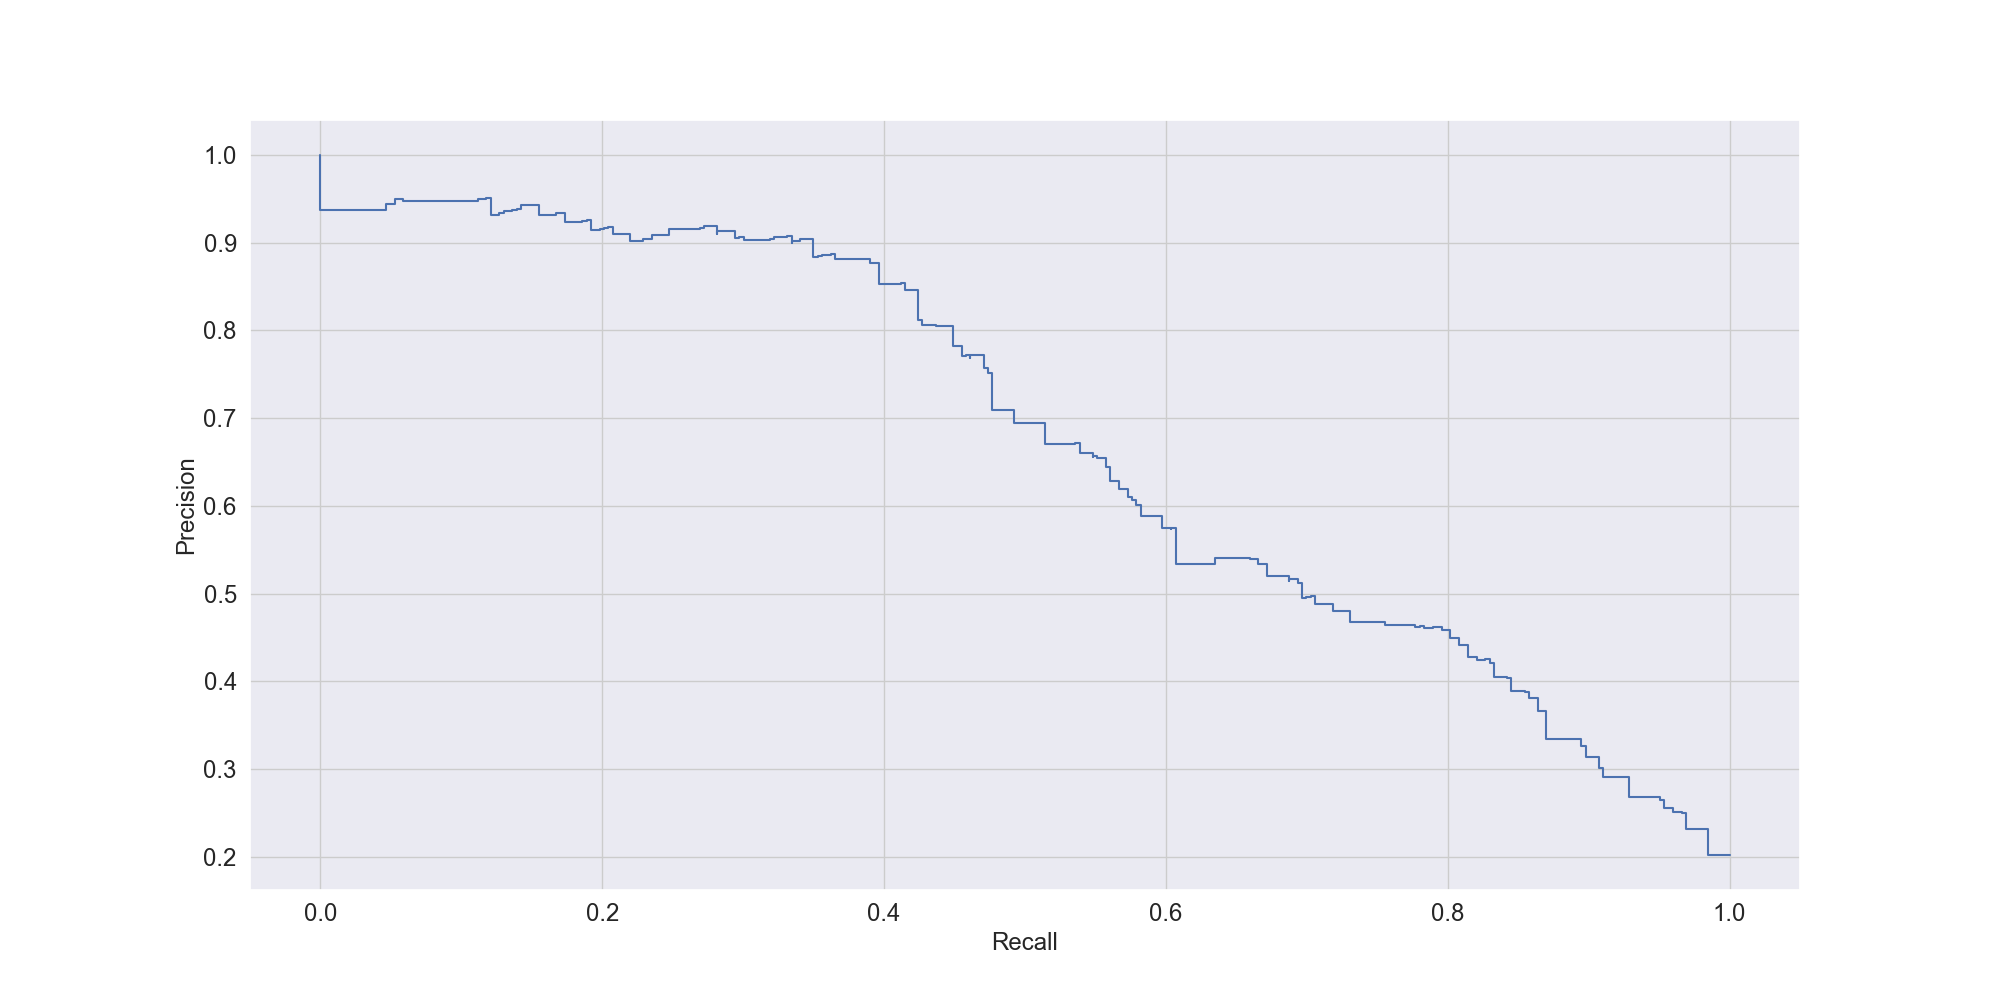
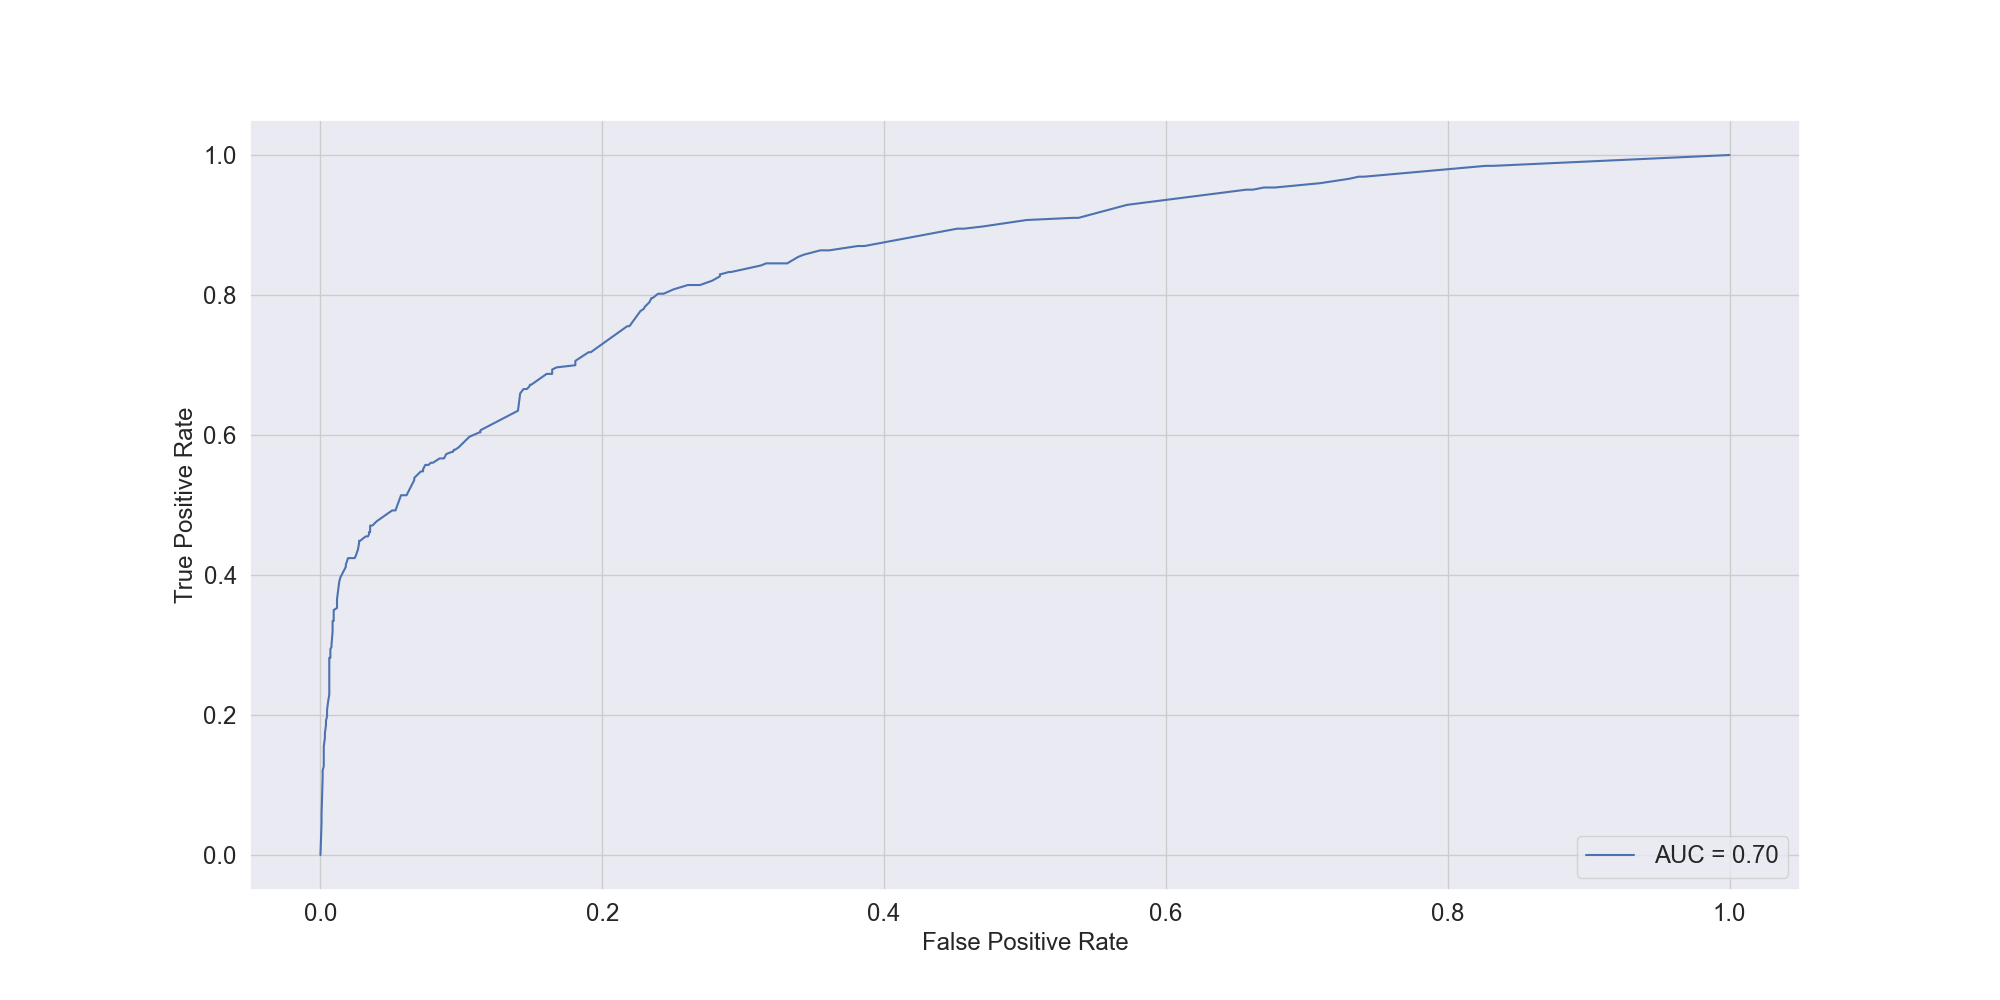
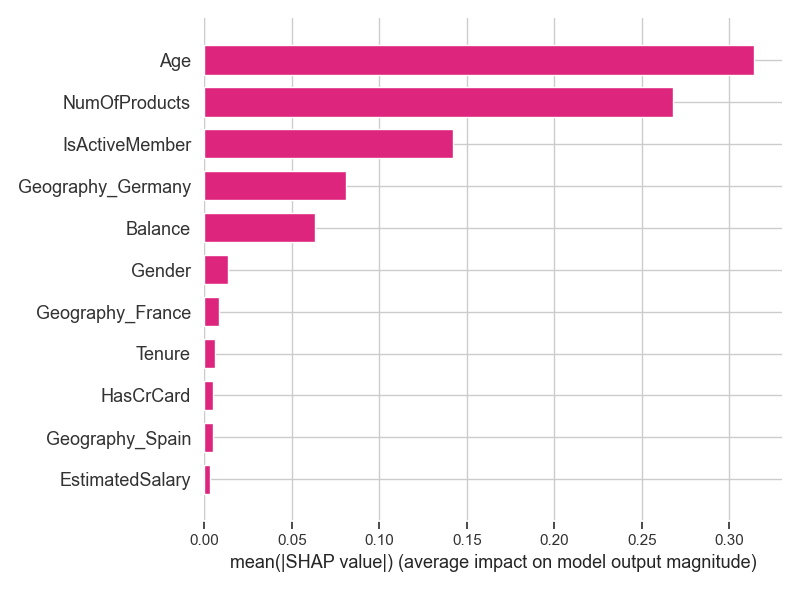
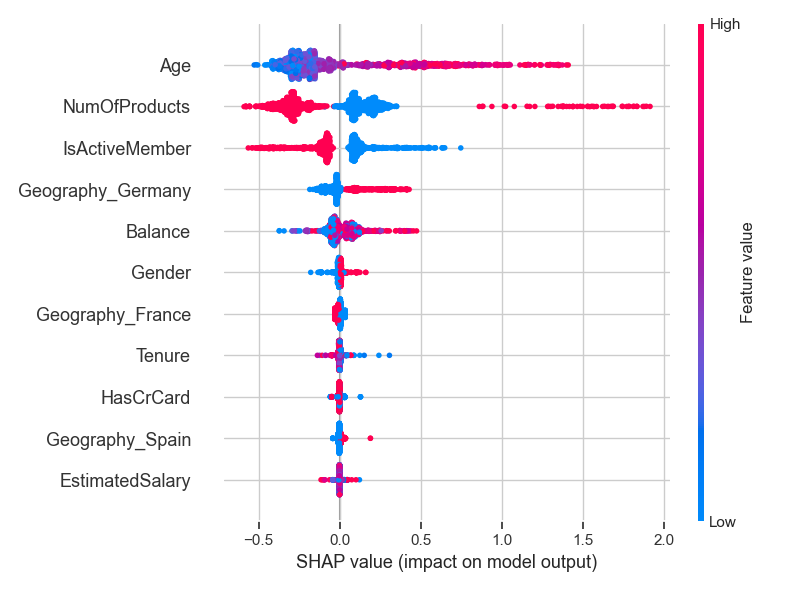

In [7]:
vm.run_test_plan("sklearn_classifier", model=vm_model, train_ds=vm_train_ds, test_ds=vm_test_ds, send=False)